<a href="https://colab.research.google.com/github/Tamar-m/RAVIR/blob/main/RAVIR_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerImageProcessor, SegformerConfig
import pandas as pd
import cv2
import numpy as np
import albumentations as aug
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
WIDTH = 768
HEIGHT = 768
# in training we randomly crop image to 256. In test dataset we need to employ a sliding window (9 windows per image) and reconstruct the full label predictions

# Patch size
Hp = 256
Wp = 256


In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map[segmentation_map==128]=1 # the loss in the segformer network only works of the labels are 0,1,2,3,... etc so i changed it
        segmentation_map[segmentation_map==255]=2

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")


        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5),
    aug.RandomCrop(width=256, height=256),
    aug.RandomBrightnessContrast(p=0.2),
    aug.SafeRotate(p=0.5)
])

transform_val = aug.Compose([
    aug.RandomCrop(width=256, height=256),
])


In [ ]:
root_dir = './drive/MyDrive/Deep Learning Class/RAVIR'
feature_extractor = SegformerImageProcessor(do_resize=False,align=False, reduce_zero_label=False,do_normalize = False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform_val, train=False)
valid_dataset_test = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)
#when we hand in the real train set, we need to make sure the labels return to the original instead of 0 1 2!!


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))


Number of training examples: 23
Number of validation examples: 4


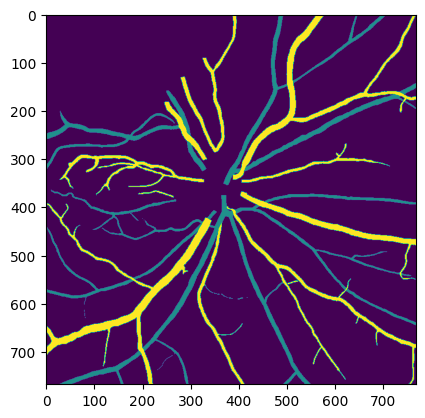

In [ ]:
encoded_inputs = valid_dataset_test[3]
import matplotlib.pyplot as plt
mask = encoded_inputs["labels"]
plt.imshow(mask.numpy())
# mask2 = mask[0:256,0:256]
# plt.imshow(mask2.numpy())

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 768, 768])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([768, 768])

In [ ]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 2])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
print(type(batch))

<class 'transformers.image_processing_utils.BatchFeature'>


In [ ]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 256, 256])
labels torch.Size([4, 256, 256])


In [ ]:
batch["labels"].shape

torch.Size([4, 256, 256])

In [ ]:
label2id = {"Background":0,"Artery":1,"Vein":2}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    ground_truth_oh = nn.functional.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = nn.functional.softmax(predictions, dim=1).permute(0, 2, 3, 1)

    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)

    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()

    CE = nn.functional.cross_entropy(predictions, ground_truths)

    return (1.0 - dice_mean) + CE

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [ ]:
NUM_EPOCHS = 600
for epoch in range(1, NUM_EPOCHS):
    if epoch % 51 == 0:
      learning_rate = learning_rate / 2
      for g in optimizer.param_groups:
        g['lr'] = learning_rate
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = dice_coef_loss(upsampled_logits, labels, num_classes=3)
        #loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}\
         Learning Rate: {learning_rate}")

Epoch: 1


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.3172164948195239         Train Loss: 1.6108265121777852         Val Pixel-wise accuracy: 0.009870696535944235         Val Loss: 0.4279714524745941         Learning Rate: 0.001
Epoch: 2


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.31681863085042933         Train Loss: 0.9164900978406271         Val Pixel-wise accuracy: 0.14941283776080264         Val Loss: 0.301675945520401         Learning Rate: 0.001
Epoch: 3


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.3648862186704184         Train Loss: 0.8553262650966644         Val Pixel-wise accuracy: 0.44645340751043117         Val Loss: 0.24059510231018066         Learning Rate: 0.001
Epoch: 4


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.3883105830202553         Train Loss: 0.8274916211764017         Val Pixel-wise accuracy: 0.5594474750374836         Val Loss: 0.2225772738456726         Learning Rate: 0.001
Epoch: 5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.3987056807663992         Train Loss: 0.7880797187487284         Val Pixel-wise accuracy: 0.39305372741414385         Val Loss: 0.3029603958129883         Learning Rate: 0.001
Epoch: 6


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4319616620242647         Train Loss: 0.7910799582799276         Val Pixel-wise accuracy: 0.45801746750064853         Val Loss: 0.3432712256908417         Learning Rate: 0.001
Epoch: 7


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.41889922189816736         Train Loss: 0.8104374210039774         Val Pixel-wise accuracy: 0.5800637156270959         Val Loss: 0.260291188955307         Learning Rate: 0.001
Epoch: 8


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.45297493664282334         Train Loss: 0.7240765690803528         Val Pixel-wise accuracy: 0.5474309634730943         Val Loss: 0.2949557900428772         Learning Rate: 0.001
Epoch: 9


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4405709000657745         Train Loss: 0.774977465470632         Val Pixel-wise accuracy: 0.5906991644197657         Val Loss: 0.2487456202507019         Learning Rate: 0.001
Epoch: 10


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.45376084297096786         Train Loss: 0.7432554264863332         Val Pixel-wise accuracy: 0.6058654364627644         Val Loss: 0.2223944365978241         Learning Rate: 0.001
Epoch: 11


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.49432576710947823         Train Loss: 0.6865062912305196         Val Pixel-wise accuracy: 0.6652320792262483         Val Loss: 0.24467790126800537         Learning Rate: 0.001
Epoch: 12


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4770668403124072         Train Loss: 0.7010410825411478         Val Pixel-wise accuracy: 0.31914637449959365         Val Loss: 0.3178369402885437         Learning Rate: 0.001
Epoch: 13


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.48916009520957143         Train Loss: 0.6830424865086874         Val Pixel-wise accuracy: 0.5807573721242786         Val Loss: 0.20595821738243103         Learning Rate: 0.001
Epoch: 14


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.47214434572441477         Train Loss: 0.7014951010545095         Val Pixel-wise accuracy: 0.597468000279779         Val Loss: 0.28544533252716064         Learning Rate: 0.001
Epoch: 15


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.467907611387994         Train Loss: 0.6837780972321829         Val Pixel-wise accuracy: 0.4451299255131631         Val Loss: 0.2604827880859375         Learning Rate: 0.001
Epoch: 16


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.48907185765255884         Train Loss: 0.6596225996812185         Val Pixel-wise accuracy: 0.5891638827459653         Val Loss: 0.23566599190235138         Learning Rate: 0.001
Epoch: 17


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.47487828585297787         Train Loss: 0.6740318934122721         Val Pixel-wise accuracy: 0.5284651419123726         Val Loss: 0.24898767471313477         Learning Rate: 0.001
Epoch: 18


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4946350127203414         Train Loss: 0.6668279071648916         Val Pixel-wise accuracy: 0.4776980221295803         Val Loss: 0.264177143573761         Learning Rate: 0.001
Epoch: 19


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5021644851100345         Train Loss: 0.6734351217746735         Val Pixel-wise accuracy: 0.6341544106589672         Val Loss: 0.21517843008041382         Learning Rate: 0.001
Epoch: 20


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5189196475944623         Train Loss: 0.6406027575333914         Val Pixel-wise accuracy: 0.54880629489434         Val Loss: 0.21410563588142395         Learning Rate: 0.001
Epoch: 21


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.49526583105135485         Train Loss: 0.6551539500554403         Val Pixel-wise accuracy: 0.5663798119621475         Val Loss: 0.23490948975086212         Learning Rate: 0.001
Epoch: 22


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5311621930010503         Train Loss: 0.6347837050755819         Val Pixel-wise accuracy: 0.6069474945098822         Val Loss: 0.14649242162704468         Learning Rate: 0.001
Epoch: 23


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5267931113557562         Train Loss: 0.6436261634031931         Val Pixel-wise accuracy: 0.6223839648096502         Val Loss: 0.2720179855823517         Learning Rate: 0.001
Epoch: 24


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.48544000607305726         Train Loss: 0.6654324134190878         Val Pixel-wise accuracy: 0.5888027834888502         Val Loss: 0.2799801528453827         Learning Rate: 0.001
Epoch: 25


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5059825806801204         Train Loss: 0.6416346232096354         Val Pixel-wise accuracy: 0.6056389293313921         Val Loss: 0.2207186222076416         Learning Rate: 0.001
Epoch: 26


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5097598995799306         Train Loss: 0.6512497166792551         Val Pixel-wise accuracy: 0.5883135129710472         Val Loss: 0.2438814640045166         Learning Rate: 0.001
Epoch: 27


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5064381185232679         Train Loss: 0.6358518997828165         Val Pixel-wise accuracy: 0.6224913944274859         Val Loss: 0.1698201298713684         Learning Rate: 0.001
Epoch: 28


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5416698216296294         Train Loss: 0.6334789395332336         Val Pixel-wise accuracy: 0.6777646738637395         Val Loss: 0.1768224984407425         Learning Rate: 0.001
Epoch: 29


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5498839570271016         Train Loss: 0.5841291745503744         Val Pixel-wise accuracy: 0.6602896270935504         Val Loss: 0.20199811458587646         Learning Rate: 0.001
Epoch: 30


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5463769009259692         Train Loss: 0.6179561614990234         Val Pixel-wise accuracy: 0.6582691167753408         Val Loss: 0.2197413146495819         Learning Rate: 0.001
Epoch: 31


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5038853443819472         Train Loss: 0.6453542411327362         Val Pixel-wise accuracy: 0.6710681662834773         Val Loss: 0.17116159200668335         Learning Rate: 0.001
Epoch: 32


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5426728471781573         Train Loss: 0.6333638330300649         Val Pixel-wise accuracy: 0.4760160005378332         Val Loss: 0.23319265246391296         Learning Rate: 0.001
Epoch: 33


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.48579202780285957         Train Loss: 0.6428385575612386         Val Pixel-wise accuracy: 0.6432400238237046         Val Loss: 0.15989533066749573         Learning Rate: 0.001
Epoch: 34


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.53353841746265         Train Loss: 0.6328433354695638         Val Pixel-wise accuracy: 0.5722516055912353         Val Loss: 0.19322367012500763         Learning Rate: 0.001
Epoch: 35


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5231984185013757         Train Loss: 0.6192539036273956         Val Pixel-wise accuracy: 0.6610995977081555         Val Loss: 0.20457103848457336         Learning Rate: 0.001
Epoch: 36


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5332965178424337         Train Loss: 0.610357532898585         Val Pixel-wise accuracy: 0.648221670802316         Val Loss: 0.21361404657363892         Learning Rate: 0.001
Epoch: 37


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5215982114514045         Train Loss: 0.6372162501017252         Val Pixel-wise accuracy: 0.7027946127946127         Val Loss: 0.1595596820116043         Learning Rate: 0.001
Epoch: 38


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.552093986977627         Train Loss: 0.6084147691726685         Val Pixel-wise accuracy: 0.731980115990058         Val Loss: 0.16442808508872986         Learning Rate: 0.001
Epoch: 39


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5679344095162145         Train Loss: 0.601069817940394         Val Pixel-wise accuracy: 0.6185486596812355         Val Loss: 0.2392691820859909         Learning Rate: 0.001
Epoch: 40


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5491032491888209         Train Loss: 0.5786823381980261         Val Pixel-wise accuracy: 0.6444104050986077         Val Loss: 0.18848218023777008         Learning Rate: 0.001
Epoch: 41


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5381567071590581         Train Loss: 0.6148807803789774         Val Pixel-wise accuracy: 0.6240093366626859         Val Loss: 0.2248082011938095         Learning Rate: 0.001
Epoch: 42


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5544999305029318         Train Loss: 0.5965153773625692         Val Pixel-wise accuracy: 0.673796169829415         Val Loss: 0.18784160912036896         Learning Rate: 0.001
Epoch: 43


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5155223333123818         Train Loss: 0.6327261030673981         Val Pixel-wise accuracy: 0.6276460805592355         Val Loss: 0.22245122492313385         Learning Rate: 0.001
Epoch: 44


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5562725462303818         Train Loss: 0.5900618135929108         Val Pixel-wise accuracy: 0.6421749387325073         Val Loss: 0.20760002732276917         Learning Rate: 0.001
Epoch: 45


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5625263994501539         Train Loss: 0.5643610209226608         Val Pixel-wise accuracy: 0.6400998432692866         Val Loss: 0.20349004864692688         Learning Rate: 0.001
Epoch: 46


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.49774969189851764         Train Loss: 0.6308726668357849         Val Pixel-wise accuracy: 0.6426560554382545         Val Loss: 0.2251519113779068         Learning Rate: 0.001
Epoch: 47


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5515267183981125         Train Loss: 0.6141363978385925         Val Pixel-wise accuracy: 0.6663249323650862         Val Loss: 0.17633837461471558         Learning Rate: 0.001
Epoch: 48


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5897971065789464         Train Loss: 0.573723832766215         Val Pixel-wise accuracy: 0.6909980171844019         Val Loss: 0.18217819929122925         Learning Rate: 0.001
Epoch: 49


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5412924679221757         Train Loss: 0.6100380917390188         Val Pixel-wise accuracy: 0.6486245353159852         Val Loss: 0.2018156200647354         Learning Rate: 0.001
Epoch: 50


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.528194670356159         Train Loss: 0.6319716175397238         Val Pixel-wise accuracy: 0.6769819863211637         Val Loss: 0.1849362701177597         Learning Rate: 0.001
Epoch: 51


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5516029346100287         Train Loss: 0.581761638323466         Val Pixel-wise accuracy: 0.6581646260152746         Val Loss: 0.20703281462192535         Learning Rate: 0.0005
Epoch: 52


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.604114324602305         Train Loss: 0.5393113891283671         Val Pixel-wise accuracy: 0.7093648765120218         Val Loss: 0.16027545928955078         Learning Rate: 0.0005
Epoch: 53


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.54457562184315         Train Loss: 0.5873483320077261         Val Pixel-wise accuracy: 0.5894880870936078         Val Loss: 0.19603417813777924         Learning Rate: 0.0005
Epoch: 54


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5549159722922777         Train Loss: 0.5507540802160898         Val Pixel-wise accuracy: 0.602941536953058         Val Loss: 0.23648449778556824         Learning Rate: 0.0005
Epoch: 55


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5359571892363809         Train Loss: 0.6151896913846334         Val Pixel-wise accuracy: 0.720533728687917         Val Loss: 0.15281942486763         Learning Rate: 0.0005
Epoch: 56


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5757653464213287         Train Loss: 0.5649129996697108         Val Pixel-wise accuracy: 0.6974388474813666         Val Loss: 0.17550252377986908         Learning Rate: 0.0005
Epoch: 57


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5846507875885005         Train Loss: 0.5646096467971802         Val Pixel-wise accuracy: 0.7405013618946493         Val Loss: 0.1834784746170044         Learning Rate: 0.0005
Epoch: 58


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5651927287117117         Train Loss: 0.5715351700782776         Val Pixel-wise accuracy: 0.6622469515804428         Val Loss: 0.12338489294052124         Learning Rate: 0.0005
Epoch: 59


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6049311405468999         Train Loss: 0.5405773123105367         Val Pixel-wise accuracy: 0.6663137887063013         Val Loss: 0.20151753723621368         Learning Rate: 0.0005
Epoch: 60


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5729985279574734         Train Loss: 0.5693695445855459         Val Pixel-wise accuracy: 0.7246940152269588         Val Loss: 0.14394401013851166         Learning Rate: 0.0005
Epoch: 61


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6089154444929566         Train Loss: 0.5535414516925812         Val Pixel-wise accuracy: 0.6464818367473235         Val Loss: 0.2015373855829239         Learning Rate: 0.0005
Epoch: 62


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5727188429874365         Train Loss: 0.5789118508497874         Val Pixel-wise accuracy: 0.6775683506899618         Val Loss: 0.16906237602233887         Learning Rate: 0.0005
Epoch: 63


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5907243533001869         Train Loss: 0.5399439086516699         Val Pixel-wise accuracy: 0.7149788149546662         Val Loss: 0.19598214328289032         Learning Rate: 0.0005
Epoch: 64


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.598389746499611         Train Loss: 0.5381197134653727         Val Pixel-wise accuracy: 0.6624404990186568         Val Loss: 0.2394593358039856         Learning Rate: 0.0005
Epoch: 65


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5810064102178126         Train Loss: 0.5650002658367157         Val Pixel-wise accuracy: 0.7321749753962059         Val Loss: 0.12622517347335815         Learning Rate: 0.0005
Epoch: 66


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6043967070241155         Train Loss: 0.5381799538930258         Val Pixel-wise accuracy: 0.6499517618413194         Val Loss: 0.24500513076782227         Learning Rate: 0.0005
Epoch: 67


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6137936160094849         Train Loss: 0.5214193115631739         Val Pixel-wise accuracy: 0.7100989944046641         Val Loss: 0.11904177069664001         Learning Rate: 0.0005
Epoch: 68


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5872231821001997         Train Loss: 0.5522629966338476         Val Pixel-wise accuracy: 0.7787760089122076         Val Loss: 0.1255195438861847         Learning Rate: 0.0005
Epoch: 69


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5926917757209248         Train Loss: 0.5673460066318512         Val Pixel-wise accuracy: 0.7270909141412738         Val Loss: 0.1984964907169342         Learning Rate: 0.0005
Epoch: 70


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6214665059664987         Train Loss: 0.515948141614596         Val Pixel-wise accuracy: 0.7780396182832078         Val Loss: 0.14980758726596832         Learning Rate: 0.0005
Epoch: 71


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.575748624862102         Train Loss: 0.5480914016564687         Val Pixel-wise accuracy: 0.6188203476116613         Val Loss: 0.13877949118614197         Learning Rate: 0.0005
Epoch: 72


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5867606785464549         Train Loss: 0.5293962707122167         Val Pixel-wise accuracy: 0.6659558421969677         Val Loss: 0.1919059306383133         Learning Rate: 0.0005
Epoch: 73


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.610488917780042         Train Loss: 0.5196208705504736         Val Pixel-wise accuracy: 0.6299383385492517         Val Loss: 0.19693249464035034         Learning Rate: 0.0005
Epoch: 74


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.581095534119541         Train Loss: 0.5452355792125066         Val Pixel-wise accuracy: 0.7106550657181393         Val Loss: 0.16856318712234497         Learning Rate: 0.0005
Epoch: 75


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5775787322555166         Train Loss: 0.5500501046578089         Val Pixel-wise accuracy: 0.7434595768794862         Val Loss: 0.17820869386196136         Learning Rate: 0.0005
Epoch: 76


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5795050192233405         Train Loss: 0.566872109969457         Val Pixel-wise accuracy: 0.649738547232011         Val Loss: 0.19964814186096191         Learning Rate: 0.0005
Epoch: 77


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5954946349823393         Train Loss: 0.5394156724214554         Val Pixel-wise accuracy: 0.7081395680579726         Val Loss: 0.16215769946575165         Learning Rate: 0.0005
Epoch: 78


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6044531172493419         Train Loss: 0.5310745338598887         Val Pixel-wise accuracy: 0.6598750339581635         Val Loss: 0.1975371092557907         Learning Rate: 0.0005
Epoch: 79


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6360414634793825         Train Loss: 0.5139392465353012         Val Pixel-wise accuracy: 0.6550779243021065         Val Loss: 0.15729594230651855         Learning Rate: 0.0005
Epoch: 80


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5960249711041733         Train Loss: 0.5529151360193888         Val Pixel-wise accuracy: 0.5174905739421869         Val Loss: 0.20663192868232727         Learning Rate: 0.0005
Epoch: 81


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6192532297111258         Train Loss: 0.5065658390522003         Val Pixel-wise accuracy: 0.5710725104490203         Val Loss: 0.17787019908428192         Learning Rate: 0.0005
Epoch: 82


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5864266056804838         Train Loss: 0.5579947829246521         Val Pixel-wise accuracy: 0.6246430924665056         Val Loss: 0.19004219770431519         Learning Rate: 0.0005
Epoch: 83


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5884834480739954         Train Loss: 0.5319172789653143         Val Pixel-wise accuracy: 0.8075548992521316         Val Loss: 0.12215662002563477         Learning Rate: 0.0005
Epoch: 84


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6037309059941228         Train Loss: 0.5314224511384964         Val Pixel-wise accuracy: 0.6873404255319149         Val Loss: 0.17163139581680298         Learning Rate: 0.0005
Epoch: 85


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6642167643843838         Train Loss: 0.492068350315094         Val Pixel-wise accuracy: 0.6613396209937996         Val Loss: 0.17657536268234253         Learning Rate: 0.0005
Epoch: 86


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5792367541839764         Train Loss: 0.567779133717219         Val Pixel-wise accuracy: 0.7345100562253489         Val Loss: 0.14288857579231262         Learning Rate: 0.0005
Epoch: 87


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5935232220356449         Train Loss: 0.515452598532041         Val Pixel-wise accuracy: 0.7399333162349321         Val Loss: 0.137625589966774         Learning Rate: 0.0005
Epoch: 88


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6498713710120819         Train Loss: 0.5211595992247263         Val Pixel-wise accuracy: 0.736127194766987         Val Loss: 0.19862553477287292         Learning Rate: 0.0005
Epoch: 89


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5914340403225555         Train Loss: 0.576835478345553         Val Pixel-wise accuracy: 0.7400941915227629         Val Loss: 0.14519798755645752         Learning Rate: 0.0005
Epoch: 90


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6352136539565124         Train Loss: 0.49075303475062054         Val Pixel-wise accuracy: 0.7367675922648734         Val Loss: 0.1263820230960846         Learning Rate: 0.0005
Epoch: 91


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5770377603767819         Train Loss: 0.5525717635949453         Val Pixel-wise accuracy: 0.633675701956971         Val Loss: 0.18352550268173218         Learning Rate: 0.0005
Epoch: 92


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6252260141731069         Train Loss: 0.5032193412383398         Val Pixel-wise accuracy: 0.6498511622015327         Val Loss: 0.18561631441116333         Learning Rate: 0.0005
Epoch: 93


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6151055933647744         Train Loss: 0.5325732827186584         Val Pixel-wise accuracy: 0.65067521944632         Val Loss: 0.17062661051750183         Learning Rate: 0.0005
Epoch: 94


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6126065411438729         Train Loss: 0.5321448345979055         Val Pixel-wise accuracy: 0.6653555778469986         Val Loss: 0.18077796697616577         Learning Rate: 0.0005
Epoch: 95


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5781359959686937         Train Loss: 0.5421198258797327         Val Pixel-wise accuracy: 0.7555784414692757         Val Loss: 0.1391575187444687         Learning Rate: 0.0005
Epoch: 96


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6281630230570342         Train Loss: 0.5044349084297816         Val Pixel-wise accuracy: 0.788255902115088         Val Loss: 0.1444167196750641         Learning Rate: 0.0005
Epoch: 97


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.632767329609105         Train Loss: 0.5302373667558035         Val Pixel-wise accuracy: 0.7436719104033146         Val Loss: 0.1310376673936844         Learning Rate: 0.0005
Epoch: 98


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5776847833766593         Train Loss: 0.5343305319547653         Val Pixel-wise accuracy: 0.7555377711721497         Val Loss: 0.12995606660842896         Learning Rate: 0.0005
Epoch: 99


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6318910166500317         Train Loss: 0.49066677192846936         Val Pixel-wise accuracy: 0.6745858993416861         Val Loss: 0.20478075742721558         Learning Rate: 0.0005
Epoch: 100


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6121580861754509         Train Loss: 0.5540745258331299         Val Pixel-wise accuracy: 0.6840740879888793         Val Loss: 0.14873698353767395         Learning Rate: 0.0005
Epoch: 101


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6260863524263429         Train Loss: 0.5117597232262293         Val Pixel-wise accuracy: 0.6642990483995811         Val Loss: 0.11760258674621582         Learning Rate: 0.0005
Epoch: 102


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5804026785480949         Train Loss: 0.5634304881095886         Val Pixel-wise accuracy: 0.8073800339869986         Val Loss: 0.12733402848243713         Learning Rate: 0.00025
Epoch: 103


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6411752672099312         Train Loss: 0.4905274560054143         Val Pixel-wise accuracy: 0.6536629758835129         Val Loss: 0.16512742638587952         Learning Rate: 0.00025
Epoch: 104


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6307291050761685         Train Loss: 0.5232929289340973         Val Pixel-wise accuracy: 0.7596638071753551         Val Loss: 0.12183871865272522         Learning Rate: 0.00025
Epoch: 105


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6561795557605811         Train Loss: 0.4776983708143234         Val Pixel-wise accuracy: 0.6570400181385331         Val Loss: 0.1847008913755417         Learning Rate: 0.00025
Epoch: 106


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6261847430581116         Train Loss: 0.4778193881114324         Val Pixel-wise accuracy: 0.7664069787963593         Val Loss: 0.1446751356124878         Learning Rate: 0.00025
Epoch: 107


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6511101514318173         Train Loss: 0.48929089804490405         Val Pixel-wise accuracy: 0.7336872646459658         Val Loss: 0.1397843062877655         Learning Rate: 0.00025
Epoch: 108


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6010624249924627         Train Loss: 0.5418489426374435         Val Pixel-wise accuracy: 0.6294787457842188         Val Loss: 0.17066402733325958         Learning Rate: 0.00025
Epoch: 109


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.626864832900394         Train Loss: 0.520166426897049         Val Pixel-wise accuracy: 0.7104770813844715         Val Loss: 0.15024349093437195         Learning Rate: 0.00025
Epoch: 110


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6485119052245273         Train Loss: 0.4878557672103246         Val Pixel-wise accuracy: 0.6849725411882177         Val Loss: 0.17198219895362854         Learning Rate: 0.00025
Epoch: 111


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6672598356008991         Train Loss: 0.4619966745376587         Val Pixel-wise accuracy: 0.6983437659109287         Val Loss: 0.15939390659332275         Learning Rate: 0.00025
Epoch: 112


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6485615957987515         Train Loss: 0.48585158586502075         Val Pixel-wise accuracy: 0.6937705592105263         Val Loss: 0.13407570123672485         Learning Rate: 0.00025
Epoch: 113


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.638150490384843         Train Loss: 0.4935423731803894         Val Pixel-wise accuracy: 0.747765044699106         Val Loss: 0.12229610979557037         Learning Rate: 0.00025
Epoch: 114


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6316550727031657         Train Loss: 0.5041137486696243         Val Pixel-wise accuracy: 0.6952215311145831         Val Loss: 0.15035846829414368         Learning Rate: 0.00025
Epoch: 115


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6871919523235207         Train Loss: 0.4340998629728953         Val Pixel-wise accuracy: 0.7140277129067414         Val Loss: 0.16205692291259766         Learning Rate: 0.00025
Epoch: 116


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6462346743885903         Train Loss: 0.5091608365376791         Val Pixel-wise accuracy: 0.7121207007121882         Val Loss: 0.1360083967447281         Learning Rate: 0.00025
Epoch: 117


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6644613053326653         Train Loss: 0.4541686326265335         Val Pixel-wise accuracy: 0.6565587148870372         Val Loss: 0.1854102611541748         Learning Rate: 0.00025
Epoch: 118


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6300886908528118         Train Loss: 0.5086735735336939         Val Pixel-wise accuracy: 0.8102233548193674         Val Loss: 0.10429401695728302         Learning Rate: 0.00025
Epoch: 119


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6197291762618358         Train Loss: 0.5176487962404887         Val Pixel-wise accuracy: 0.7539521907991904         Val Loss: 0.16398409008979797         Learning Rate: 0.00025
Epoch: 120


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6471037547120231         Train Loss: 0.49915165702501935         Val Pixel-wise accuracy: 0.7522548774734271         Val Loss: 0.1502908170223236         Learning Rate: 0.00025
Epoch: 121


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6690761602054126         Train Loss: 0.4770145167907079         Val Pixel-wise accuracy: 0.7450214633831456         Val Loss: 0.12935960292816162         Learning Rate: 0.00025
Epoch: 122


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6961155737772134         Train Loss: 0.4470541179180145         Val Pixel-wise accuracy: 0.7662071705841         Val Loss: 0.13533750176429749         Learning Rate: 0.00025
Epoch: 123


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6618670345479388         Train Loss: 0.46799425780773163         Val Pixel-wise accuracy: 0.7441545328940377         Val Loss: 0.15500640869140625         Learning Rate: 0.00025
Epoch: 124


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6685229960556209         Train Loss: 0.4373708814382553         Val Pixel-wise accuracy: 0.7919406508177373         Val Loss: 0.11454188078641891         Learning Rate: 0.00025
Epoch: 125


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6463053802670277         Train Loss: 0.4951356401046117         Val Pixel-wise accuracy: 0.7668098141085318         Val Loss: 0.13331961631774902         Learning Rate: 0.00025
Epoch: 126


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6474689049696669         Train Loss: 0.49040770530700684         Val Pixel-wise accuracy: 0.756459248274682         Val Loss: 0.13394643366336823         Learning Rate: 0.00025
Epoch: 127


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6500792347499897         Train Loss: 0.4840250114599864         Val Pixel-wise accuracy: 0.7821518921988745         Val Loss: 0.1384585201740265         Learning Rate: 0.00025
Epoch: 128


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6641423928876238         Train Loss: 0.4819570730129878         Val Pixel-wise accuracy: 0.7662132542547705         Val Loss: 0.12982219457626343         Learning Rate: 0.00025
Epoch: 129


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6561308233625721         Train Loss: 0.48982814451058704         Val Pixel-wise accuracy: 0.8172728791845374         Val Loss: 0.12950456142425537         Learning Rate: 0.00025
Epoch: 130


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.67895226467577         Train Loss: 0.4430622061093648         Val Pixel-wise accuracy: 0.7907828223177588         Val Loss: 0.15289326012134552         Learning Rate: 0.00025
Epoch: 131


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6062489853926673         Train Loss: 0.5224429965019226         Val Pixel-wise accuracy: 0.7622531293463143         Val Loss: 0.1298755407333374         Learning Rate: 0.00025
Epoch: 132


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6597437261226777         Train Loss: 0.48437991738319397         Val Pixel-wise accuracy: 0.8014313180944242         Val Loss: 0.1321556717157364         Learning Rate: 0.00025
Epoch: 133


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6810354810232943         Train Loss: 0.450990026195844         Val Pixel-wise accuracy: 0.7441516779007317         Val Loss: 0.11935985088348389         Learning Rate: 0.00025
Epoch: 134


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6443938939105517         Train Loss: 0.4881238142649333         Val Pixel-wise accuracy: 0.7433343455815365         Val Loss: 0.1240253895521164         Learning Rate: 0.00025
Epoch: 135


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6605908888972145         Train Loss: 0.47664982577164966         Val Pixel-wise accuracy: 0.8005890781722655         Val Loss: 0.14198175072669983         Learning Rate: 0.00025
Epoch: 136


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6642117615769487         Train Loss: 0.4681122750043869         Val Pixel-wise accuracy: 0.751705612475337         Val Loss: 0.15159207582473755         Learning Rate: 0.00025
Epoch: 137


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6392770995240159         Train Loss: 0.4687536805868149         Val Pixel-wise accuracy: 0.7543239421298814         Val Loss: 0.14104914665222168         Learning Rate: 0.00025
Epoch: 138


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6095772929179044         Train Loss: 0.5324762215216955         Val Pixel-wise accuracy: 0.6792338360201075         Val Loss: 0.17271755635738373         Learning Rate: 0.00025
Epoch: 139


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6431154435966228         Train Loss: 0.48676797747612         Val Pixel-wise accuracy: 0.595297234641497         Val Loss: 0.20846150815486908         Learning Rate: 0.00025
Epoch: 140


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.679244465588153         Train Loss: 0.4705388794342677         Val Pixel-wise accuracy: 0.7167106180473463         Val Loss: 0.14700698852539062         Learning Rate: 0.00025
Epoch: 141


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7017513186538098         Train Loss: 0.42564937472343445         Val Pixel-wise accuracy: 0.7777574442498235         Val Loss: 0.14889299869537354         Learning Rate: 0.00025
Epoch: 142


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6559487106827837         Train Loss: 0.4889785299698512         Val Pixel-wise accuracy: 0.8257888749176696         Val Loss: 0.11040835082530975         Learning Rate: 0.00025
Epoch: 143


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6900736348389712         Train Loss: 0.44252318640549976         Val Pixel-wise accuracy: 0.6460637198082767         Val Loss: 0.1894543319940567         Learning Rate: 0.00025
Epoch: 144


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6295531464812083         Train Loss: 0.510854701201121         Val Pixel-wise accuracy: 0.7214318921431893         Val Loss: 0.1833358108997345         Learning Rate: 0.00025
Epoch: 145


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6540033465213021         Train Loss: 0.4776168465614319         Val Pixel-wise accuracy: 0.8380506868782568         Val Loss: 0.1021447628736496         Learning Rate: 0.00025
Epoch: 146


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6605320554263233         Train Loss: 0.48496829469998676         Val Pixel-wise accuracy: 0.6645811380400422         Val Loss: 0.1702563762664795         Learning Rate: 0.00025
Epoch: 147


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6620869762183764         Train Loss: 0.44448356827100116         Val Pixel-wise accuracy: 0.7214830092813844         Val Loss: 0.1760718673467636         Learning Rate: 0.00025
Epoch: 148


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6207827000368445         Train Loss: 0.5017641087373098         Val Pixel-wise accuracy: 0.7740636632986402         Val Loss: 0.1574489027261734         Learning Rate: 0.00025
Epoch: 149


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6508728367440725         Train Loss: 0.4880094329516093         Val Pixel-wise accuracy: 0.7127007396548277         Val Loss: 0.14727851748466492         Learning Rate: 0.00025
Epoch: 150


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6480525430651832         Train Loss: 0.49759355187416077         Val Pixel-wise accuracy: 0.8638557039119231         Val Loss: 0.11300257593393326         Learning Rate: 0.00025
Epoch: 151


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6505913702266483         Train Loss: 0.4862419317166011         Val Pixel-wise accuracy: 0.6955690049860453         Val Loss: 0.14741623401641846         Learning Rate: 0.00025
Epoch: 152


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6514604532755267         Train Loss: 0.4843473881483078         Val Pixel-wise accuracy: 0.7806553228846601         Val Loss: 0.14672702550888062         Learning Rate: 0.00025
Epoch: 153


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6492058595560367         Train Loss: 0.5098389436801275         Val Pixel-wise accuracy: 0.7606997053018628         Val Loss: 0.136402428150177         Learning Rate: 0.000125
Epoch: 154


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6765038339055408         Train Loss: 0.4401419510444005         Val Pixel-wise accuracy: 0.7380449669025336         Val Loss: 0.1457158774137497         Learning Rate: 0.000125
Epoch: 155


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.685875321051235         Train Loss: 0.4304838826258977         Val Pixel-wise accuracy: 0.7223449641932044         Val Loss: 0.12179270386695862         Learning Rate: 0.000125
Epoch: 156


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6615933156376097         Train Loss: 0.4812570810317993         Val Pixel-wise accuracy: 0.7406193490054249         Val Loss: 0.155782550573349         Learning Rate: 0.000125
Epoch: 157


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6944753200120198         Train Loss: 0.45574649175008136         Val Pixel-wise accuracy: 0.8235452296439711         Val Loss: 0.11433765292167664         Learning Rate: 0.000125
Epoch: 158


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6552388285256473         Train Loss: 0.4809218446413676         Val Pixel-wise accuracy: 0.7779863331084846         Val Loss: 0.12212317436933517         Learning Rate: 0.000125
Epoch: 159


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6674956494168814         Train Loss: 0.4294909139474233         Val Pixel-wise accuracy: 0.8347210870453616         Val Loss: 0.10950885713100433         Learning Rate: 0.000125
Epoch: 160


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6662331235924329         Train Loss: 0.4499992976586024         Val Pixel-wise accuracy: 0.7849986161084971         Val Loss: 0.13419245183467865         Learning Rate: 0.000125
Epoch: 161


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6906290084314306         Train Loss: 0.44579824308554333         Val Pixel-wise accuracy: 0.8189238120677885         Val Loss: 0.11630846560001373         Learning Rate: 0.000125
Epoch: 162


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.643641392423901         Train Loss: 0.5025368332862854         Val Pixel-wise accuracy: 0.7060329176463586         Val Loss: 0.1619616150856018         Learning Rate: 0.000125
Epoch: 163


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6743488107735326         Train Loss: 0.46221696337064105         Val Pixel-wise accuracy: 0.8176184024674987         Val Loss: 0.11853425949811935         Learning Rate: 0.000125
Epoch: 164


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6756397308705931         Train Loss: 0.4439530322949092         Val Pixel-wise accuracy: 0.7691393739022626         Val Loss: 0.1528889387845993         Learning Rate: 0.000125
Epoch: 165


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6893048484885355         Train Loss: 0.42675039172172546         Val Pixel-wise accuracy: 0.8460149082568807         Val Loss: 0.10205391049385071         Learning Rate: 0.000125
Epoch: 166


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6460035512295468         Train Loss: 0.49046042561531067         Val Pixel-wise accuracy: 0.7751233602118185         Val Loss: 0.12420398741960526         Learning Rate: 0.000125
Epoch: 167


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6834190938645944         Train Loss: 0.443179115653038         Val Pixel-wise accuracy: 0.6930089078368168         Val Loss: 0.15667706727981567         Learning Rate: 0.000125
Epoch: 168


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6502765879007061         Train Loss: 0.4729955891768138         Val Pixel-wise accuracy: 0.7320708343836653         Val Loss: 0.1330363154411316         Learning Rate: 0.000125
Epoch: 169


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6335322813723978         Train Loss: 0.49465496838092804         Val Pixel-wise accuracy: 0.8254454605449232         Val Loss: 0.13220733404159546         Learning Rate: 0.000125
Epoch: 170


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6892424478341166         Train Loss: 0.43250182767709094         Val Pixel-wise accuracy: 0.7773351415494152         Val Loss: 0.13013142347335815         Learning Rate: 0.000125
Epoch: 171


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6930781282149989         Train Loss: 0.4567778408527374         Val Pixel-wise accuracy: 0.8245742003720048         Val Loss: 0.10144247859716415         Learning Rate: 0.000125
Epoch: 172


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7001217186689604         Train Loss: 0.42846567928791046         Val Pixel-wise accuracy: 0.8124072335140702         Val Loss: 0.11210351437330246         Learning Rate: 0.000125
Epoch: 173


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6611524710478497         Train Loss: 0.4901999334494273         Val Pixel-wise accuracy: 0.7677417269906929         Val Loss: 0.1195240169763565         Learning Rate: 0.000125
Epoch: 174


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6856410140694384         Train Loss: 0.4418911933898926         Val Pixel-wise accuracy: 0.769102029638195         Val Loss: 0.1216588169336319         Learning Rate: 0.000125
Epoch: 175


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6567746010532325         Train Loss: 0.4557681828737259         Val Pixel-wise accuracy: 0.8343506850750569         Val Loss: 0.10398302227258682         Learning Rate: 0.000125
Epoch: 176


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6780549557747353         Train Loss: 0.44728773335615796         Val Pixel-wise accuracy: 0.7922754077458428         Val Loss: 0.12866848707199097         Learning Rate: 0.000125
Epoch: 177


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.698743848953673         Train Loss: 0.4352455983559291         Val Pixel-wise accuracy: 0.7608734371103908         Val Loss: 0.11051329225301743         Learning Rate: 0.000125
Epoch: 178


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6749656830505399         Train Loss: 0.4724889745314916         Val Pixel-wise accuracy: 0.8243232660732465         Val Loss: 0.11198236793279648         Learning Rate: 0.000125
Epoch: 179


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7035015555316427         Train Loss: 0.41815251111984253         Val Pixel-wise accuracy: 0.7987939002990534         Val Loss: 0.14365887641906738         Learning Rate: 0.000125
Epoch: 180


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6725398322998438         Train Loss: 0.45512592295805615         Val Pixel-wise accuracy: 0.8353444325645334         Val Loss: 0.0938020646572113         Learning Rate: 0.000125
Epoch: 181


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6763759939594451         Train Loss: 0.45556064943472546         Val Pixel-wise accuracy: 0.809856777740271         Val Loss: 0.1597442775964737         Learning Rate: 0.000125
Epoch: 182


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6973680281302795         Train Loss: 0.44838401178518933         Val Pixel-wise accuracy: 0.848608862963076         Val Loss: 0.10158538818359375         Learning Rate: 0.000125
Epoch: 183


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.702848343448025         Train Loss: 0.4363335371017456         Val Pixel-wise accuracy: 0.6968829880584487         Val Loss: 0.14665134251117706         Learning Rate: 0.000125
Epoch: 184


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6648262280728003         Train Loss: 0.4583769490321477         Val Pixel-wise accuracy: 0.7943462101588017         Val Loss: 0.14252883195877075         Learning Rate: 0.000125
Epoch: 185


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6630920422420724         Train Loss: 0.46084292232990265         Val Pixel-wise accuracy: 0.7998505521268646         Val Loss: 0.132481649518013         Learning Rate: 0.000125
Epoch: 186


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.668627348233922         Train Loss: 0.473317950963974         Val Pixel-wise accuracy: 0.8225984796129924         Val Loss: 0.1386701911687851         Learning Rate: 0.000125
Epoch: 187


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6661929409706256         Train Loss: 0.4643919418255488         Val Pixel-wise accuracy: 0.7201219512195122         Val Loss: 0.15989241003990173         Learning Rate: 0.000125
Epoch: 188


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6383523530047895         Train Loss: 0.4806886961062749         Val Pixel-wise accuracy: 0.7045979353436567         Val Loss: 0.12942837178707123         Learning Rate: 0.000125
Epoch: 189


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6768992014125828         Train Loss: 0.4365393320719401         Val Pixel-wise accuracy: 0.6870825635924399         Val Loss: 0.1807243674993515         Learning Rate: 0.000125
Epoch: 190


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6621269428199672         Train Loss: 0.4694570104281108         Val Pixel-wise accuracy: 0.7252490660024906         Val Loss: 0.13402801752090454         Learning Rate: 0.000125
Epoch: 191


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6780133223316019         Train Loss: 0.462670495112737         Val Pixel-wise accuracy: 0.8601137324936554         Val Loss: 0.1033124327659607         Learning Rate: 0.000125
Epoch: 192


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7062665125720109         Train Loss: 0.4495443105697632         Val Pixel-wise accuracy: 0.7611013846888429         Val Loss: 0.11991273611783981         Learning Rate: 0.000125
Epoch: 193


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6948687707499563         Train Loss: 0.42137626310189563         Val Pixel-wise accuracy: 0.7720381995458795         Val Loss: 0.10736281424760818         Learning Rate: 0.000125
Epoch: 194


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6536441973566002         Train Loss: 0.4804924875497818         Val Pixel-wise accuracy: 0.748401249256395         Val Loss: 0.12156146764755249         Learning Rate: 0.000125
Epoch: 195


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7051335929138091         Train Loss: 0.4240906834602356         Val Pixel-wise accuracy: 0.8469609655322388         Val Loss: 0.11147677898406982         Learning Rate: 0.000125
Epoch: 196


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6846477034519931         Train Loss: 0.4519878973563512         Val Pixel-wise accuracy: 0.7742403107136019         Val Loss: 0.1368018090724945         Learning Rate: 0.000125
Epoch: 197


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.67172308593439         Train Loss: 0.4677070180575053         Val Pixel-wise accuracy: 0.838708746826679         Val Loss: 0.10986955463886261         Learning Rate: 0.000125
Epoch: 198


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6914412875459991         Train Loss: 0.44325051208337146         Val Pixel-wise accuracy: 0.8293778237439443         Val Loss: 0.12826403975486755         Learning Rate: 0.000125
Epoch: 199


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6587507108755207         Train Loss: 0.44418541093667346         Val Pixel-wise accuracy: 0.8455163991625959         Val Loss: 0.12454517185688019         Learning Rate: 0.000125
Epoch: 200


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6625962341502357         Train Loss: 0.45091333488623303         Val Pixel-wise accuracy: 0.7933096085409252         Val Loss: 0.1343219131231308         Learning Rate: 0.000125
Epoch: 201


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6962391424258211         Train Loss: 0.45459894835948944         Val Pixel-wise accuracy: 0.8240514383309333         Val Loss: 0.10219662636518478         Learning Rate: 0.000125
Epoch: 202


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.692524090638785         Train Loss: 0.4541771014531453         Val Pixel-wise accuracy: 0.8128314973480212         Val Loss: 0.10411179065704346         Learning Rate: 0.000125
Epoch: 203


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6854190186475307         Train Loss: 0.4323895076910655         Val Pixel-wise accuracy: 0.8073881887818137         Val Loss: 0.126919686794281         Learning Rate: 0.000125
Epoch: 204


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6581123218816461         Train Loss: 0.4593534469604492         Val Pixel-wise accuracy: 0.6933304339722283         Val Loss: 0.16217073798179626         Learning Rate: 6.25e-05
Epoch: 205


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6348084048572411         Train Loss: 0.491722971200943         Val Pixel-wise accuracy: 0.7800855393732703         Val Loss: 0.12702679634094238         Learning Rate: 6.25e-05
Epoch: 206


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6621362745132334         Train Loss: 0.47431882719198865         Val Pixel-wise accuracy: 0.8143085958355579         Val Loss: 0.09879808127880096         Learning Rate: 6.25e-05
Epoch: 207


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7058219641801146         Train Loss: 0.4277009069919586         Val Pixel-wise accuracy: 0.8042281044590514         Val Loss: 0.14088110625743866         Learning Rate: 6.25e-05
Epoch: 208


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6908315941101192         Train Loss: 0.43829014897346497         Val Pixel-wise accuracy: 0.8093107073134104         Val Loss: 0.11862616240978241         Learning Rate: 6.25e-05
Epoch: 209


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7375225717559338         Train Loss: 0.40123863021532696         Val Pixel-wise accuracy: 0.8075438460143519         Val Loss: 0.15108107030391693         Learning Rate: 6.25e-05
Epoch: 210


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7138912452562266         Train Loss: 0.4269705464442571         Val Pixel-wise accuracy: 0.6786880379934699         Val Loss: 0.1397150307893753         Learning Rate: 6.25e-05
Epoch: 211


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6997540101212133         Train Loss: 0.43700137237707776         Val Pixel-wise accuracy: 0.843292759442841         Val Loss: 0.11187536269426346         Learning Rate: 6.25e-05
Epoch: 212


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7224790251782226         Train Loss: 0.3838786433140437         Val Pixel-wise accuracy: 0.7678176615944856         Val Loss: 0.11479683220386505         Learning Rate: 6.25e-05
Epoch: 213


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6531648610375732         Train Loss: 0.4859561522801717         Val Pixel-wise accuracy: 0.7891397849462366         Val Loss: 0.13191311061382294         Learning Rate: 6.25e-05
Epoch: 214


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6699356283579639         Train Loss: 0.4684745321671168         Val Pixel-wise accuracy: 0.7426608026388125         Val Loss: 0.1564587950706482         Learning Rate: 6.25e-05
Epoch: 215


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6626779699345295         Train Loss: 0.458514670530955         Val Pixel-wise accuracy: 0.7009879001378465         Val Loss: 0.1297726184129715         Learning Rate: 6.25e-05
Epoch: 216


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6710874190185917         Train Loss: 0.4500085959831874         Val Pixel-wise accuracy: 0.754410790630457         Val Loss: 0.13510818779468536         Learning Rate: 6.25e-05
Epoch: 217


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6956906206765731         Train Loss: 0.43876610696315765         Val Pixel-wise accuracy: 0.6843306762471464         Val Loss: 0.1405426263809204         Learning Rate: 6.25e-05
Epoch: 218


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7201481875931953         Train Loss: 0.41765541831652325         Val Pixel-wise accuracy: 0.7301688146669087         Val Loss: 0.15049950778484344         Learning Rate: 6.25e-05
Epoch: 219


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6807852966244369         Train Loss: 0.46140597263971966         Val Pixel-wise accuracy: 0.7369720762363072         Val Loss: 0.14534646272659302         Learning Rate: 6.25e-05
Epoch: 220


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6917767314506666         Train Loss: 0.4403192102909088         Val Pixel-wise accuracy: 0.8028328795539997         Val Loss: 0.10641855001449585         Learning Rate: 6.25e-05
Epoch: 221


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6606494809306515         Train Loss: 0.46031976242860156         Val Pixel-wise accuracy: 0.7737586206896552         Val Loss: 0.11703439801931381         Learning Rate: 6.25e-05
Epoch: 222


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.653589164862451         Train Loss: 0.47233515481154126         Val Pixel-wise accuracy: 0.7602082442985353         Val Loss: 0.1083189845085144         Learning Rate: 6.25e-05
Epoch: 223


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6999657738986215         Train Loss: 0.4090076684951782         Val Pixel-wise accuracy: 0.7054536131560635         Val Loss: 0.13259458541870117         Learning Rate: 6.25e-05
Epoch: 224


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6956467851544036         Train Loss: 0.41949879626433056         Val Pixel-wise accuracy: 0.7534370987441671         Val Loss: 0.13372968137264252         Learning Rate: 6.25e-05
Epoch: 225


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6942798893208915         Train Loss: 0.42724936207135517         Val Pixel-wise accuracy: 0.760315661335684         Val Loss: 0.1051422730088234         Learning Rate: 6.25e-05
Epoch: 226


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.697043278867662         Train Loss: 0.42191678782304126         Val Pixel-wise accuracy: 0.8482318419699307         Val Loss: 0.0894380658864975         Learning Rate: 6.25e-05
Epoch: 227


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6694757619552348         Train Loss: 0.4608316322167714         Val Pixel-wise accuracy: 0.7860022080156102         Val Loss: 0.15108622610569         Learning Rate: 6.25e-05
Epoch: 228


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.693125199815836         Train Loss: 0.43155087033907574         Val Pixel-wise accuracy: 0.8071779560863345         Val Loss: 0.10618990659713745         Learning Rate: 6.25e-05
Epoch: 229


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6473226252903544         Train Loss: 0.49652694662412006         Val Pixel-wise accuracy: 0.781913837601747         Val Loss: 0.11574099957942963         Learning Rate: 6.25e-05
Epoch: 230


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7257551434194127         Train Loss: 0.38024763762950897         Val Pixel-wise accuracy: 0.7844521974002588         Val Loss: 0.1355079710483551         Learning Rate: 6.25e-05
Epoch: 231


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6951146545113226         Train Loss: 0.42610546946525574         Val Pixel-wise accuracy: 0.7369519210706728         Val Loss: 0.15388387441635132         Learning Rate: 6.25e-05
Epoch: 232


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6761980132712111         Train Loss: 0.4254700690507889         Val Pixel-wise accuracy: 0.7349158341734641         Val Loss: 0.1541503369808197         Learning Rate: 6.25e-05
Epoch: 233


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6365597164576137         Train Loss: 0.5027510623137156         Val Pixel-wise accuracy: 0.7454654392940792         Val Loss: 0.15811946988105774         Learning Rate: 6.25e-05
Epoch: 234


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6752157327743982         Train Loss: 0.46195050080617267         Val Pixel-wise accuracy: 0.6663174014669139         Val Loss: 0.13712812960147858         Learning Rate: 6.25e-05
Epoch: 235


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6814192348495073         Train Loss: 0.446371595064799         Val Pixel-wise accuracy: 0.7324906590348994         Val Loss: 0.12843890488147736         Learning Rate: 6.25e-05
Epoch: 236


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7041940598864725         Train Loss: 0.450991893808047         Val Pixel-wise accuracy: 0.8144566964038344         Val Loss: 0.1344401091337204         Learning Rate: 6.25e-05
Epoch: 237


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6965559923287882         Train Loss: 0.4205777843793233         Val Pixel-wise accuracy: 0.7744877816350146         Val Loss: 0.11419746279716492         Learning Rate: 6.25e-05
Epoch: 238


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6931915760433797         Train Loss: 0.43194010357062024         Val Pixel-wise accuracy: 0.793428953509715         Val Loss: 0.13325901329517365         Learning Rate: 6.25e-05
Epoch: 239


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6849593419030011         Train Loss: 0.44485733409722644         Val Pixel-wise accuracy: 0.7895414054767403         Val Loss: 0.11423467844724655         Learning Rate: 6.25e-05
Epoch: 240


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6908141495341883         Train Loss: 0.4324614703655243         Val Pixel-wise accuracy: 0.7290335139343996         Val Loss: 0.13524168729782104         Learning Rate: 6.25e-05
Epoch: 241


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6593966877405317         Train Loss: 0.47203725079695386         Val Pixel-wise accuracy: 0.8330016112216851         Val Loss: 0.10425443947315216         Learning Rate: 6.25e-05
Epoch: 242


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7090973452052228         Train Loss: 0.41623235245545703         Val Pixel-wise accuracy: 0.8146222299773164         Val Loss: 0.10047094523906708         Learning Rate: 6.25e-05
Epoch: 243


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7075437431463416         Train Loss: 0.411611740787824         Val Pixel-wise accuracy: 0.7722348198538674         Val Loss: 0.09592419862747192         Learning Rate: 6.25e-05
Epoch: 244


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6982311302354375         Train Loss: 0.4310530771811803         Val Pixel-wise accuracy: 0.8172206692314079         Val Loss: 0.09868177771568298         Learning Rate: 6.25e-05
Epoch: 245


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7160925356175882         Train Loss: 0.38687491913636524         Val Pixel-wise accuracy: 0.7757029482529536         Val Loss: 0.10983584821224213         Learning Rate: 6.25e-05
Epoch: 246


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7241892912158111         Train Loss: 0.3944451262553533         Val Pixel-wise accuracy: 0.8079413182726083         Val Loss: 0.10041488707065582         Learning Rate: 6.25e-05
Epoch: 247


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7080087770042741         Train Loss: 0.43515560527642566         Val Pixel-wise accuracy: 0.8281797037581099         Val Loss: 0.13626424968242645         Learning Rate: 6.25e-05
Epoch: 248


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7177282038937024         Train Loss: 0.40982415278752643         Val Pixel-wise accuracy: 0.8417531044558072         Val Loss: 0.10010470449924469         Learning Rate: 6.25e-05
Epoch: 249


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6892148691434233         Train Loss: 0.4574332783619563         Val Pixel-wise accuracy: 0.8437427142968164         Val Loss: 0.11580519378185272         Learning Rate: 6.25e-05
Epoch: 250


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7328472696407012         Train Loss: 0.39919141431649524         Val Pixel-wise accuracy: 0.8491062668995717         Val Loss: 0.10762996971607208         Learning Rate: 6.25e-05
Epoch: 251


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6997336144002344         Train Loss: 0.43504729866981506         Val Pixel-wise accuracy: 0.8518838164394976         Val Loss: 0.09281369298696518         Learning Rate: 6.25e-05
Epoch: 252


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6764257002510865         Train Loss: 0.4469967434803645         Val Pixel-wise accuracy: 0.8055108496586936         Val Loss: 0.12385514378547668         Learning Rate: 6.25e-05
Epoch: 253


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6777790403513778         Train Loss: 0.4382577935854594         Val Pixel-wise accuracy: 0.7705199076341753         Val Loss: 0.11793000251054764         Learning Rate: 6.25e-05
Epoch: 254


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6829049647527619         Train Loss: 0.438195859392484         Val Pixel-wise accuracy: 0.8253505043456195         Val Loss: 0.10259345173835754         Learning Rate: 6.25e-05
Epoch: 255


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6941494650872966         Train Loss: 0.44420291980107623         Val Pixel-wise accuracy: 0.8113781193753953         Val Loss: 0.13940592110157013         Learning Rate: 3.125e-05
Epoch: 256


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6907200028887063         Train Loss: 0.43758875131607056         Val Pixel-wise accuracy: 0.7721922072346059         Val Loss: 0.11272535473108292         Learning Rate: 3.125e-05
Epoch: 257


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7062279859670958         Train Loss: 0.41924818356831867         Val Pixel-wise accuracy: 0.7817211910075663         Val Loss: 0.13413222134113312         Learning Rate: 3.125e-05
Epoch: 258


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6987949633251777         Train Loss: 0.42000188926855725         Val Pixel-wise accuracy: 0.7853476283300844         Val Loss: 0.11537431925535202         Learning Rate: 3.125e-05
Epoch: 259


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7005934487353498         Train Loss: 0.42110200226306915         Val Pixel-wise accuracy: 0.7332275917926566         Val Loss: 0.14477621018886566         Learning Rate: 3.125e-05
Epoch: 260


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7131911928894384         Train Loss: 0.39893163243929547         Val Pixel-wise accuracy: 0.8487977239353891         Val Loss: 0.12605148553848267         Learning Rate: 3.125e-05
Epoch: 261


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6910239786459457         Train Loss: 0.4373875508705775         Val Pixel-wise accuracy: 0.8378147120595327         Val Loss: 0.11990658938884735         Learning Rate: 3.125e-05
Epoch: 262


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.718997554256676         Train Loss: 0.4014556556940079         Val Pixel-wise accuracy: 0.7793850544888428         Val Loss: 0.1216941773891449         Learning Rate: 3.125e-05
Epoch: 263


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7193167633176675         Train Loss: 0.4049261162678401         Val Pixel-wise accuracy: 0.8811627794678643         Val Loss: 0.09812135249376297         Learning Rate: 3.125e-05
Epoch: 264


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7156910197580834         Train Loss: 0.41152676939964294         Val Pixel-wise accuracy: 0.7875050751116525         Val Loss: 0.14820414781570435         Learning Rate: 3.125e-05
Epoch: 265


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7225023235167187         Train Loss: 0.4221656521161397         Val Pixel-wise accuracy: 0.8479881953044716         Val Loss: 0.11754069477319717         Learning Rate: 3.125e-05
Epoch: 266


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7083341786758358         Train Loss: 0.4079773674408595         Val Pixel-wise accuracy: 0.8072804099176765         Val Loss: 0.13439327478408813         Learning Rate: 3.125e-05
Epoch: 267


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.694028580535133         Train Loss: 0.4217698872089386         Val Pixel-wise accuracy: 0.7764459172578057         Val Loss: 0.15676623582839966         Learning Rate: 3.125e-05
Epoch: 268


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7050329232326592         Train Loss: 0.4153088877598445         Val Pixel-wise accuracy: 0.7707061557244693         Val Loss: 0.10995239019393921         Learning Rate: 3.125e-05
Epoch: 269


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7020017816454519         Train Loss: 0.4234310984611511         Val Pixel-wise accuracy: 0.8485272737063163         Val Loss: 0.11002882570028305         Learning Rate: 3.125e-05
Epoch: 270


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7252447084889605         Train Loss: 0.41371337572733563         Val Pixel-wise accuracy: 0.8104975815334514         Val Loss: 0.1414860188961029         Learning Rate: 3.125e-05
Epoch: 271


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7152710123847191         Train Loss: 0.41896037260691327         Val Pixel-wise accuracy: 0.644965053067564         Val Loss: 0.12464563548564911         Learning Rate: 3.125e-05
Epoch: 272


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7386899110577333         Train Loss: 0.38012179732322693         Val Pixel-wise accuracy: 0.7707948243992606         Val Loss: 0.13660097122192383         Learning Rate: 3.125e-05
Epoch: 273


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6690960840033396         Train Loss: 0.45868193606535596         Val Pixel-wise accuracy: 0.8031777384029977         Val Loss: 0.12395911663770676         Learning Rate: 3.125e-05
Epoch: 274


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6943190560073608         Train Loss: 0.4092343598604202         Val Pixel-wise accuracy: 0.7572212065813528         Val Loss: 0.1473170667886734         Learning Rate: 3.125e-05
Epoch: 275


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7291254592724933         Train Loss: 0.39587782323360443         Val Pixel-wise accuracy: 0.8248175182481752         Val Loss: 0.138345867395401         Learning Rate: 3.125e-05
Epoch: 276


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7270149977478848         Train Loss: 0.3958091338475545         Val Pixel-wise accuracy: 0.7337214560253221         Val Loss: 0.1584644913673401         Learning Rate: 3.125e-05
Epoch: 277


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.696772937574667         Train Loss: 0.43145201603571576         Val Pixel-wise accuracy: 0.7054507337526206         Val Loss: 0.1552148163318634         Learning Rate: 3.125e-05
Epoch: 278


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7351578660041197         Train Loss: 0.38914693892002106         Val Pixel-wise accuracy: 0.7850441244774733         Val Loss: 0.1582745611667633         Learning Rate: 3.125e-05
Epoch: 279


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6810029979450394         Train Loss: 0.43638715147972107         Val Pixel-wise accuracy: 0.8540823807325749         Val Loss: 0.10671070218086243         Learning Rate: 3.125e-05
Epoch: 280


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6963859659175232         Train Loss: 0.4450451036294301         Val Pixel-wise accuracy: 0.829365537963712         Val Loss: 0.103430837392807         Learning Rate: 3.125e-05
Epoch: 281


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7106351845365181         Train Loss: 0.4061296135187149         Val Pixel-wise accuracy: 0.8634005423888692         Val Loss: 0.09241629391908646         Learning Rate: 3.125e-05
Epoch: 282


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7133053761544087         Train Loss: 0.40341563026110333         Val Pixel-wise accuracy: 0.779871966651779         Val Loss: 0.12398682534694672         Learning Rate: 3.125e-05
Epoch: 283


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7129218206233311         Train Loss: 0.43024998406569165         Val Pixel-wise accuracy: 0.8230916834370758         Val Loss: 0.14726503193378448         Learning Rate: 3.125e-05
Epoch: 284


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7355361902068496         Train Loss: 0.37879278759161633         Val Pixel-wise accuracy: 0.7596063436344261         Val Loss: 0.13202905654907227         Learning Rate: 3.125e-05
Epoch: 285


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6894437542528943         Train Loss: 0.4606963445742925         Val Pixel-wise accuracy: 0.8336760713991939         Val Loss: 0.10899348556995392         Learning Rate: 3.125e-05
Epoch: 286


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.74680699865963         Train Loss: 0.3816096981366475         Val Pixel-wise accuracy: 0.788283378746594         Val Loss: 0.13273367285728455         Learning Rate: 3.125e-05
Epoch: 287


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7258935456138902         Train Loss: 0.3759477188189824         Val Pixel-wise accuracy: 0.8008369888569555         Val Loss: 0.1348172277212143         Learning Rate: 3.125e-05
Epoch: 288


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6990833850204382         Train Loss: 0.4207836588223775         Val Pixel-wise accuracy: 0.7882067291016303         Val Loss: 0.11042186617851257         Learning Rate: 3.125e-05
Epoch: 289


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7135946043403646         Train Loss: 0.4229382425546646         Val Pixel-wise accuracy: 0.784014889943893         Val Loss: 0.14010155200958252         Learning Rate: 3.125e-05
Epoch: 290


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6949761272455809         Train Loss: 0.4295254151026408         Val Pixel-wise accuracy: 0.6966833159653599         Val Loss: 0.15535442531108856         Learning Rate: 3.125e-05
Epoch: 291


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7437408006080067         Train Loss: 0.3640136867761612         Val Pixel-wise accuracy: 0.7019085343896291         Val Loss: 0.14220331609249115         Learning Rate: 3.125e-05
Epoch: 292


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7098589027695871         Train Loss: 0.4139446218808492         Val Pixel-wise accuracy: 0.7850464405838244         Val Loss: 0.13125528395175934         Learning Rate: 3.125e-05
Epoch: 293


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7283229761359657         Train Loss: 0.39674700299898785         Val Pixel-wise accuracy: 0.8010361872538394         Val Loss: 0.1414506584405899         Learning Rate: 3.125e-05
Epoch: 294


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7063058025927292         Train Loss: 0.44911664227644604         Val Pixel-wise accuracy: 0.6419024683925346         Val Loss: 0.14399518072605133         Learning Rate: 3.125e-05
Epoch: 295


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.676669613752853         Train Loss: 0.46727393567562103         Val Pixel-wise accuracy: 0.7677657177964367         Val Loss: 0.1196139007806778         Learning Rate: 3.125e-05
Epoch: 296


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.699024660954834         Train Loss: 0.4088301658630371         Val Pixel-wise accuracy: 0.8019515333476303         Val Loss: 0.1338253915309906         Learning Rate: 3.125e-05
Epoch: 297


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6598852344823521         Train Loss: 0.45553827782471973         Val Pixel-wise accuracy: 0.7816492124547266         Val Loss: 0.1310555338859558         Learning Rate: 3.125e-05
Epoch: 298


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7071114860061046         Train Loss: 0.4082738707462947         Val Pixel-wise accuracy: 0.6986856823266219         Val Loss: 0.13876374065876007         Learning Rate: 3.125e-05
Epoch: 299


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7409566943920166         Train Loss: 0.36239684621493023         Val Pixel-wise accuracy: 0.815613102167962         Val Loss: 0.10996747761964798         Learning Rate: 3.125e-05
Epoch: 300


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6979192954732995         Train Loss: 0.4484453996022542         Val Pixel-wise accuracy: 0.8351676543779984         Val Loss: 0.12997455894947052         Learning Rate: 3.125e-05
Epoch: 301


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7187772377259548         Train Loss: 0.41451795895894367         Val Pixel-wise accuracy: 0.848786949247072         Val Loss: 0.09073996543884277         Learning Rate: 3.125e-05
Epoch: 302


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6832708262282264         Train Loss: 0.43807214001814526         Val Pixel-wise accuracy: 0.6797948717948717         Val Loss: 0.12986022233963013         Learning Rate: 3.125e-05
Epoch: 303


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.703572814782726         Train Loss: 0.42060479521751404         Val Pixel-wise accuracy: 0.8322220845210063         Val Loss: 0.12259534001350403         Learning Rate: 3.125e-05
Epoch: 304


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6836877437675538         Train Loss: 0.4453580329815547         Val Pixel-wise accuracy: 0.8399561292499789         Val Loss: 0.10840599238872528         Learning Rate: 3.125e-05
Epoch: 305


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7325927969511888         Train Loss: 0.3844366818666458         Val Pixel-wise accuracy: 0.834407535944472         Val Loss: 0.11071845889091492         Learning Rate: 3.125e-05
Epoch: 306


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6943659097426563         Train Loss: 0.4453216592470805         Val Pixel-wise accuracy: 0.9056785859406745         Val Loss: 0.08799855411052704         Learning Rate: 1.5625e-05
Epoch: 307


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7151974318174111         Train Loss: 0.4145490229129791         Val Pixel-wise accuracy: 0.7349326862867878         Val Loss: 0.11931908875703812         Learning Rate: 1.5625e-05
Epoch: 308


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6908787337684156         Train Loss: 0.43624188005924225         Val Pixel-wise accuracy: 0.6832218585456098         Val Loss: 0.15771272778511047         Learning Rate: 1.5625e-05
Epoch: 309


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.740928523253867         Train Loss: 0.3737254391113917         Val Pixel-wise accuracy: 0.7521094640820981         Val Loss: 0.16360746324062347         Learning Rate: 1.5625e-05
Epoch: 310


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7130345586542188         Train Loss: 0.4038817634185155         Val Pixel-wise accuracy: 0.7803707381661702         Val Loss: 0.12226177752017975         Learning Rate: 1.5625e-05
Epoch: 311


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7289241256993703         Train Loss: 0.3848896523316701         Val Pixel-wise accuracy: 0.8240014657383657         Val Loss: 0.08678995072841644         Learning Rate: 1.5625e-05
Epoch: 312


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7166541339633428         Train Loss: 0.41554370025793713         Val Pixel-wise accuracy: 0.8013513874422455         Val Loss: 0.124866783618927         Learning Rate: 1.5625e-05
Epoch: 313


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7416411931572645         Train Loss: 0.36237141489982605         Val Pixel-wise accuracy: 0.8804167411455275         Val Loss: 0.09683389961719513         Learning Rate: 1.5625e-05
Epoch: 314


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7324123612048199         Train Loss: 0.41088322798411053         Val Pixel-wise accuracy: 0.856552750410509         Val Loss: 0.1228862926363945         Learning Rate: 1.5625e-05
Epoch: 315


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7059302608264248         Train Loss: 0.42333350082238513         Val Pixel-wise accuracy: 0.86251821626348         Val Loss: 0.10117223113775253         Learning Rate: 1.5625e-05
Epoch: 316


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7188913416481948         Train Loss: 0.4045289208491643         Val Pixel-wise accuracy: 0.8508702639392041         Val Loss: 0.10539703816175461         Learning Rate: 1.5625e-05
Epoch: 317


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.737081401905804         Train Loss: 0.3816826194524765         Val Pixel-wise accuracy: 0.7368943277658343         Val Loss: 0.13614749908447266         Learning Rate: 1.5625e-05
Epoch: 318


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7334226026851978         Train Loss: 0.3886651446421941         Val Pixel-wise accuracy: 0.7240162909277491         Val Loss: 0.1351931393146515         Learning Rate: 1.5625e-05
Epoch: 319


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7191236976671531         Train Loss: 0.3918823649485906         Val Pixel-wise accuracy: 0.8313411919874701         Val Loss: 0.11518111079931259         Learning Rate: 1.5625e-05
Epoch: 320


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7290023909475029         Train Loss: 0.434447521964709         Val Pixel-wise accuracy: 0.8382559363668265         Val Loss: 0.10381922125816345         Learning Rate: 1.5625e-05
Epoch: 321


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7214614047366537         Train Loss: 0.3895433743794759         Val Pixel-wise accuracy: 0.7480728447840577         Val Loss: 0.14215511083602905         Learning Rate: 1.5625e-05
Epoch: 322


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7113094211141431         Train Loss: 0.40253445506095886         Val Pixel-wise accuracy: 0.8294447869682319         Val Loss: 0.10562963038682938         Learning Rate: 1.5625e-05
Epoch: 323


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7148044891845663         Train Loss: 0.42721286912759143         Val Pixel-wise accuracy: 0.8523722835362385         Val Loss: 0.10141010582447052         Learning Rate: 1.5625e-05
Epoch: 324


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7047122295408221         Train Loss: 0.42604004343350727         Val Pixel-wise accuracy: 0.8474667624865253         Val Loss: 0.11387261748313904         Learning Rate: 1.5625e-05
Epoch: 325


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7093961298529047         Train Loss: 0.4164184133211772         Val Pixel-wise accuracy: 0.8103801341649994         Val Loss: 0.13712531328201294         Learning Rate: 1.5625e-05
Epoch: 326


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7303724893322494         Train Loss: 0.3731892655293147         Val Pixel-wise accuracy: 0.7598040611739242         Val Loss: 0.1503198742866516         Learning Rate: 1.5625e-05
Epoch: 327


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.716364168104285         Train Loss: 0.4100416551033656         Val Pixel-wise accuracy: 0.7477056277056277         Val Loss: 0.1219959557056427         Learning Rate: 1.5625e-05
Epoch: 328


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7176154407196331         Train Loss: 0.40825322767098743         Val Pixel-wise accuracy: 0.833463596464859         Val Loss: 0.10662548243999481         Learning Rate: 1.5625e-05
Epoch: 329


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.695361745381143         Train Loss: 0.44089214503765106         Val Pixel-wise accuracy: 0.8632022713585132         Val Loss: 0.10137969255447388         Learning Rate: 1.5625e-05
Epoch: 330


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6758312025278991         Train Loss: 0.4611149976650874         Val Pixel-wise accuracy: 0.7819982218952144         Val Loss: 0.12318208813667297         Learning Rate: 1.5625e-05
Epoch: 331


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7392473535422986         Train Loss: 0.3989099512497584         Val Pixel-wise accuracy: 0.760382046400568         Val Loss: 0.12699319422245026         Learning Rate: 1.5625e-05
Epoch: 332


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6677105963021789         Train Loss: 0.4487943301598231         Val Pixel-wise accuracy: 0.7511582198511862         Val Loss: 0.12386922538280487         Learning Rate: 1.5625e-05
Epoch: 333


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.733323387125903         Train Loss: 0.38524546722571057         Val Pixel-wise accuracy: 0.807376291247259         Val Loss: 0.12275950610637665         Learning Rate: 1.5625e-05
Epoch: 334


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6726927403509184         Train Loss: 0.4528928150733312         Val Pixel-wise accuracy: 0.8496634996041171         Val Loss: 0.0880829319357872         Learning Rate: 1.5625e-05
Epoch: 335


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6883396645939367         Train Loss: 0.43041113018989563         Val Pixel-wise accuracy: 0.7679087452471483         Val Loss: 0.11422239989042282         Learning Rate: 1.5625e-05
Epoch: 336


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6925990552224616         Train Loss: 0.4526747117439906         Val Pixel-wise accuracy: 0.7552616480961439         Val Loss: 0.1462213397026062         Learning Rate: 1.5625e-05
Epoch: 337


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7427871610332017         Train Loss: 0.38368075092633563         Val Pixel-wise accuracy: 0.8529766572169613         Val Loss: 0.09759319573640823         Learning Rate: 1.5625e-05
Epoch: 338


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7106739434880321         Train Loss: 0.4129185229539871         Val Pixel-wise accuracy: 0.8476508865142379         Val Loss: 0.09724482893943787         Learning Rate: 1.5625e-05
Epoch: 339


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7378813444052934         Train Loss: 0.39538190762201947         Val Pixel-wise accuracy: 0.7678480927120992         Val Loss: 0.12879246473312378         Learning Rate: 1.5625e-05
Epoch: 340


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7237431637571566         Train Loss: 0.39906252920627594         Val Pixel-wise accuracy: 0.7716012509223795         Val Loss: 0.12582704424858093         Learning Rate: 1.5625e-05
Epoch: 341


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7331895346246808         Train Loss: 0.390436256925265         Val Pixel-wise accuracy: 0.6910042262024553         Val Loss: 0.11885202676057816         Learning Rate: 1.5625e-05
Epoch: 342


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7062074718924927         Train Loss: 0.4235586126645406         Val Pixel-wise accuracy: 0.7914508716901306         Val Loss: 0.10900557786226273         Learning Rate: 1.5625e-05
Epoch: 343


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7401251062845621         Train Loss: 0.36462870240211487         Val Pixel-wise accuracy: 0.7659045850377695         Val Loss: 0.16759023070335388         Learning Rate: 1.5625e-05
Epoch: 344


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7289229199159369         Train Loss: 0.40504048268000287         Val Pixel-wise accuracy: 0.7621051861069429         Val Loss: 0.10262633115053177         Learning Rate: 1.5625e-05
Epoch: 345


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7243586077748052         Train Loss: 0.41217456261316937         Val Pixel-wise accuracy: 0.7851406141053121         Val Loss: 0.15569628775119781         Learning Rate: 1.5625e-05
Epoch: 346


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7303311029959741         Train Loss: 0.37717974682648975         Val Pixel-wise accuracy: 0.8295808687909432         Val Loss: 0.10198655724525452         Learning Rate: 1.5625e-05
Epoch: 347


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6956077342431674         Train Loss: 0.41871360937754315         Val Pixel-wise accuracy: 0.7700897308075773         Val Loss: 0.14413176476955414         Learning Rate: 1.5625e-05
Epoch: 348


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7100407829571358         Train Loss: 0.4094386200110118         Val Pixel-wise accuracy: 0.845566132264529         Val Loss: 0.13075239956378937         Learning Rate: 1.5625e-05
Epoch: 349


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7449126069119107         Train Loss: 0.39253437519073486         Val Pixel-wise accuracy: 0.8608473112974839         Val Loss: 0.09104840457439423         Learning Rate: 1.5625e-05
Epoch: 350


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.756322102906385         Train Loss: 0.36032022535800934         Val Pixel-wise accuracy: 0.8671094594238423         Val Loss: 0.10467475652694702         Learning Rate: 1.5625e-05
Epoch: 351


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7148798091447625         Train Loss: 0.41066837807496387         Val Pixel-wise accuracy: 0.8443028398510242         Val Loss: 0.10554298758506775         Learning Rate: 1.5625e-05
Epoch: 352


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7104317088202924         Train Loss: 0.4129589994748433         Val Pixel-wise accuracy: 0.8179211032126186         Val Loss: 0.11526992172002792         Learning Rate: 1.5625e-05
Epoch: 353


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6968416832103902         Train Loss: 0.42240066826343536         Val Pixel-wise accuracy: 0.8360976154576423         Val Loss: 0.10585629940032959         Learning Rate: 1.5625e-05
Epoch: 354


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7209970702480352         Train Loss: 0.4034116466840108         Val Pixel-wise accuracy: 0.8383239678751957         Val Loss: 0.10869331657886505         Learning Rate: 1.5625e-05
Epoch: 355


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7232009570555475         Train Loss: 0.4112591395775477         Val Pixel-wise accuracy: 0.7567773430737804         Val Loss: 0.11369077116250992         Learning Rate: 1.5625e-05
Epoch: 356


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7059812546533754         Train Loss: 0.4176255116860072         Val Pixel-wise accuracy: 0.8286906247946916         Val Loss: 0.10045657306909561         Learning Rate: 1.5625e-05
Epoch: 357


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7094088451279389         Train Loss: 0.4018489023049672         Val Pixel-wise accuracy: 0.8444196606388911         Val Loss: 0.10378330945968628         Learning Rate: 7.8125e-06
Epoch: 358


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7420598140597763         Train Loss: 0.39553849399089813         Val Pixel-wise accuracy: 0.8200980903683607         Val Loss: 0.1266615390777588         Learning Rate: 7.8125e-06
Epoch: 359


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7353916997000831         Train Loss: 0.3753054638703664         Val Pixel-wise accuracy: 0.7776127760060374         Val Loss: 0.1768694370985031         Learning Rate: 7.8125e-06
Epoch: 360


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7106018615590285         Train Loss: 0.4006328781445821         Val Pixel-wise accuracy: 0.7285669964493777         Val Loss: 0.13111767172813416         Learning Rate: 7.8125e-06
Epoch: 361


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7214293177504262         Train Loss: 0.40519218146800995         Val Pixel-wise accuracy: 0.8277113291224297         Val Loss: 0.0953061655163765         Learning Rate: 7.8125e-06
Epoch: 362


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7190031706733552         Train Loss: 0.39715218047300976         Val Pixel-wise accuracy: 0.8140479186949398         Val Loss: 0.13109427690505981         Learning Rate: 7.8125e-06
Epoch: 363


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7118412527406672         Train Loss: 0.4038279602924983         Val Pixel-wise accuracy: 0.8396980044484822         Val Loss: 0.1029185950756073         Learning Rate: 7.8125e-06
Epoch: 364


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7245319212482556         Train Loss: 0.3898560106754303         Val Pixel-wise accuracy: 0.8000182132774792         Val Loss: 0.12155601382255554         Learning Rate: 7.8125e-06
Epoch: 365


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.72320128745426         Train Loss: 0.4028271088997523         Val Pixel-wise accuracy: 0.8795645052509876         Val Loss: 0.0972880870103836         Learning Rate: 7.8125e-06
Epoch: 366


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7049678296799432         Train Loss: 0.41666529575983685         Val Pixel-wise accuracy: 0.8244918195339613         Val Loss: 0.14379805326461792         Learning Rate: 7.8125e-06
Epoch: 367


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7645620968077637         Train Loss: 0.3485027849674225         Val Pixel-wise accuracy: 0.8610493223003233         Val Loss: 0.0896340161561966         Learning Rate: 7.8125e-06
Epoch: 368


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6881281359070203         Train Loss: 0.45878006021181744         Val Pixel-wise accuracy: 0.8327224450922105         Val Loss: 0.10833306610584259         Learning Rate: 7.8125e-06
Epoch: 369


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7113526755748208         Train Loss: 0.4278678099314372         Val Pixel-wise accuracy: 0.7276326911954443         Val Loss: 0.10496601462364197         Learning Rate: 7.8125e-06
Epoch: 370


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6999434359599616         Train Loss: 0.40494731565316516         Val Pixel-wise accuracy: 0.8432321180369935         Val Loss: 0.11290919780731201         Learning Rate: 7.8125e-06
Epoch: 371


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7244467839584621         Train Loss: 0.4033552457888921         Val Pixel-wise accuracy: 0.8803433575296693         Val Loss: 0.08899624645709991         Learning Rate: 7.8125e-06
Epoch: 372


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7146339471982608         Train Loss: 0.41086478034655255         Val Pixel-wise accuracy: 0.7986558717182833         Val Loss: 0.09167458117008209         Learning Rate: 7.8125e-06
Epoch: 373


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6999519412499048         Train Loss: 0.4368091970682144         Val Pixel-wise accuracy: 0.804933393843936         Val Loss: 0.14169149100780487         Learning Rate: 7.8125e-06
Epoch: 374


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7034906664319595         Train Loss: 0.40539773801962536         Val Pixel-wise accuracy: 0.7834377819503036         Val Loss: 0.16114404797554016         Learning Rate: 7.8125e-06
Epoch: 375


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7389295695054044         Train Loss: 0.3855065703392029         Val Pixel-wise accuracy: 0.8584411137159866         Val Loss: 0.1051676794886589         Learning Rate: 7.8125e-06
Epoch: 376


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6979996100827971         Train Loss: 0.4365174223979314         Val Pixel-wise accuracy: 0.8271856927637654         Val Loss: 0.13501109182834625         Learning Rate: 7.8125e-06
Epoch: 377


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.69176024849136         Train Loss: 0.4149989535411199         Val Pixel-wise accuracy: 0.7994599763739664         Val Loss: 0.13695138692855835         Learning Rate: 7.8125e-06
Epoch: 378


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7264033958471444         Train Loss: 0.401807501912117         Val Pixel-wise accuracy: 0.8423657244291439         Val Loss: 0.11129649728536606         Learning Rate: 7.8125e-06
Epoch: 379


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.72325156533187         Train Loss: 0.3966050644715627         Val Pixel-wise accuracy: 0.8479608097739479         Val Loss: 0.1118345558643341         Learning Rate: 7.8125e-06
Epoch: 380


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7096370308564884         Train Loss: 0.43283529082934064         Val Pixel-wise accuracy: 0.8146664651350262         Val Loss: 0.12665969133377075         Learning Rate: 7.8125e-06
Epoch: 381


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6978352208193418         Train Loss: 0.42834444840749103         Val Pixel-wise accuracy: 0.8847951216732205         Val Loss: 0.09255129098892212         Learning Rate: 7.8125e-06
Epoch: 382


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.718089480397421         Train Loss: 0.39532392223676044         Val Pixel-wise accuracy: 0.8736423435826832         Val Loss: 0.0935874879360199         Learning Rate: 7.8125e-06
Epoch: 383


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6983194628699266         Train Loss: 0.4238565613826116         Val Pixel-wise accuracy: 0.7903893073087939         Val Loss: 0.10984902828931808         Learning Rate: 7.8125e-06
Epoch: 384


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7209474808391892         Train Loss: 0.4236694723367691         Val Pixel-wise accuracy: 0.8071517801374141         Val Loss: 0.11320751905441284         Learning Rate: 7.8125e-06
Epoch: 385


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.74220298140542         Train Loss: 0.38000931839148205         Val Pixel-wise accuracy: 0.8726018890740922         Val Loss: 0.07484908401966095         Learning Rate: 7.8125e-06
Epoch: 386


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6912223749642856         Train Loss: 0.43808352450529736         Val Pixel-wise accuracy: 0.8007393382021459         Val Loss: 0.11700651049613953         Learning Rate: 7.8125e-06
Epoch: 387


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7203954799467663         Train Loss: 0.406168465813001         Val Pixel-wise accuracy: 0.8052759987801159         Val Loss: 0.09143473207950592         Learning Rate: 7.8125e-06
Epoch: 388


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7225597627130642         Train Loss: 0.3963107218345006         Val Pixel-wise accuracy: 0.8621057657202236         Val Loss: 0.09805215895175934         Learning Rate: 7.8125e-06
Epoch: 389


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7175312221429637         Train Loss: 0.4097520013650258         Val Pixel-wise accuracy: 0.8537735849056604         Val Loss: 0.09753745794296265         Learning Rate: 7.8125e-06
Epoch: 390


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.690133449591282         Train Loss: 0.4404349128405253         Val Pixel-wise accuracy: 0.7768870473788506         Val Loss: 0.13633586466312408         Learning Rate: 7.8125e-06
Epoch: 391


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7035897382891193         Train Loss: 0.41278813779354095         Val Pixel-wise accuracy: 0.643088997626084         Val Loss: 0.13064616918563843         Learning Rate: 7.8125e-06
Epoch: 392


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7144720361512568         Train Loss: 0.4084259122610092         Val Pixel-wise accuracy: 0.7648717948717949         Val Loss: 0.15717387199401855         Learning Rate: 7.8125e-06
Epoch: 393


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7246688026569643         Train Loss: 0.3897284169991811         Val Pixel-wise accuracy: 0.8610805378762502         Val Loss: 0.12518736720085144         Learning Rate: 7.8125e-06
Epoch: 394


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7239714934500855         Train Loss: 0.3957710713148117         Val Pixel-wise accuracy: 0.7484651277013753         Val Loss: 0.1605066955089569         Learning Rate: 7.8125e-06
Epoch: 395


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7410196997892414         Train Loss: 0.3677622030178706         Val Pixel-wise accuracy: 0.8681697806069146         Val Loss: 0.1056356430053711         Learning Rate: 7.8125e-06
Epoch: 396


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7463406853292408         Train Loss: 0.3760548532009125         Val Pixel-wise accuracy: 0.7958338350391331         Val Loss: 0.14051926136016846         Learning Rate: 7.8125e-06
Epoch: 397


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7532299007312334         Train Loss: 0.3615271896123886         Val Pixel-wise accuracy: 0.8142523364485982         Val Loss: 0.12191285938024521         Learning Rate: 7.8125e-06
Epoch: 398


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6970771341929184         Train Loss: 0.4151630202929179         Val Pixel-wise accuracy: 0.8165991295212367         Val Loss: 0.13297630846500397         Learning Rate: 7.8125e-06
Epoch: 399


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7261563931453224         Train Loss: 0.3833284030357997         Val Pixel-wise accuracy: 0.8422847174499127         Val Loss: 0.1083938330411911         Learning Rate: 7.8125e-06
Epoch: 400


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.736476188751174         Train Loss: 0.3867304523785909         Val Pixel-wise accuracy: 0.8174703276090682         Val Loss: 0.10692392289638519         Learning Rate: 7.8125e-06
Epoch: 401


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.717034377591523         Train Loss: 0.4139701972405116         Val Pixel-wise accuracy: 0.8063078407994095         Val Loss: 0.12042246758937836         Learning Rate: 7.8125e-06
Epoch: 402


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7199330675671392         Train Loss: 0.40352124472459155         Val Pixel-wise accuracy: 0.8328533482454914         Val Loss: 0.11179360747337341         Learning Rate: 7.8125e-06
Epoch: 403


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7328941873302283         Train Loss: 0.3877297341823578         Val Pixel-wise accuracy: 0.7913750514615068         Val Loss: 0.10692042857408524         Learning Rate: 7.8125e-06
Epoch: 404


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7004545223416384         Train Loss: 0.43008539577325183         Val Pixel-wise accuracy: 0.79163818325996         Val Loss: 0.12722548842430115         Learning Rate: 7.8125e-06
Epoch: 405


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6785565692458064         Train Loss: 0.45850880940755206         Val Pixel-wise accuracy: 0.8530176973439689         Val Loss: 0.09994739294052124         Learning Rate: 7.8125e-06
Epoch: 406


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7058729049825504         Train Loss: 0.43234329919020337         Val Pixel-wise accuracy: 0.8428679466224294         Val Loss: 0.11595427989959717         Learning Rate: 7.8125e-06
Epoch: 407


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7408843035764621         Train Loss: 0.372404341896375         Val Pixel-wise accuracy: 0.8300680695207491         Val Loss: 0.0972389429807663         Learning Rate: 7.8125e-06
Epoch: 408


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7175797446885138         Train Loss: 0.4235637883345286         Val Pixel-wise accuracy: 0.7948140361415628         Val Loss: 0.14601105451583862         Learning Rate: 3.90625e-06
Epoch: 409


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7181659319750041         Train Loss: 0.38514100511868793         Val Pixel-wise accuracy: 0.7935907899823875         Val Loss: 0.07895950973033905         Learning Rate: 3.90625e-06
Epoch: 410


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7134826998132889         Train Loss: 0.41340983907381695         Val Pixel-wise accuracy: 0.8471094354215004         Val Loss: 0.11804153025150299         Learning Rate: 3.90625e-06
Epoch: 411


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6965492285816705         Train Loss: 0.4218115856250127         Val Pixel-wise accuracy: 0.8589335340435387         Val Loss: 0.09876270592212677         Learning Rate: 3.90625e-06
Epoch: 412


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6984426586262683         Train Loss: 0.4494175712267558         Val Pixel-wise accuracy: 0.777022775890273         Val Loss: 0.15462450683116913         Learning Rate: 3.90625e-06
Epoch: 413


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.736263500069171         Train Loss: 0.3834204177061717         Val Pixel-wise accuracy: 0.7597398632144602         Val Loss: 0.14083106815814972         Learning Rate: 3.90625e-06
Epoch: 414


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7446709072608492         Train Loss: 0.3671925216913223         Val Pixel-wise accuracy: 0.8244729719663298         Val Loss: 0.1252589225769043         Learning Rate: 3.90625e-06
Epoch: 415


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7015709957717619         Train Loss: 0.405843252936999         Val Pixel-wise accuracy: 0.8106802629813498         Val Loss: 0.11708249151706696         Learning Rate: 3.90625e-06
Epoch: 416


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7172226889559644         Train Loss: 0.38746096193790436         Val Pixel-wise accuracy: 0.7448953789746507         Val Loss: 0.13740405440330505         Learning Rate: 3.90625e-06
Epoch: 417


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7451039123797871         Train Loss: 0.35731281340122223         Val Pixel-wise accuracy: 0.863817447627307         Val Loss: 0.11166249215602875         Learning Rate: 3.90625e-06
Epoch: 418


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7094459306461222         Train Loss: 0.41537365814050037         Val Pixel-wise accuracy: 0.853385662223808         Val Loss: 0.1110474020242691         Learning Rate: 3.90625e-06
Epoch: 419


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7261752904288352         Train Loss: 0.41088616847991943         Val Pixel-wise accuracy: 0.8323164166247936         Val Loss: 0.09034609794616699         Learning Rate: 3.90625e-06
Epoch: 420


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7034118242057336         Train Loss: 0.4354179998238881         Val Pixel-wise accuracy: 0.8211948431311968         Val Loss: 0.1150858998298645         Learning Rate: 3.90625e-06
Epoch: 421


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7458646744289701         Train Loss: 0.37148884932200116         Val Pixel-wise accuracy: 0.7234965902045877         Val Loss: 0.13442011177539825         Learning Rate: 3.90625e-06
Epoch: 422


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7391252707931398         Train Loss: 0.36979932089646655         Val Pixel-wise accuracy: 0.842133897536648         Val Loss: 0.09710336476564407         Learning Rate: 3.90625e-06
Epoch: 423


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7303053446861288         Train Loss: 0.40366072952747345         Val Pixel-wise accuracy: 0.8017896082412211         Val Loss: 0.13590261340141296         Learning Rate: 3.90625e-06
Epoch: 424


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.704477585758899         Train Loss: 0.434019535779953         Val Pixel-wise accuracy: 0.8218951350712301         Val Loss: 0.10459962487220764         Learning Rate: 3.90625e-06
Epoch: 425


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6979879896423323         Train Loss: 0.4357479214668274         Val Pixel-wise accuracy: 0.7937741134189524         Val Loss: 0.1400863528251648         Learning Rate: 3.90625e-06
Epoch: 426


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7215269273122958         Train Loss: 0.4071383128563563         Val Pixel-wise accuracy: 0.8568668864619823         Val Loss: 0.10905486345291138         Learning Rate: 3.90625e-06
Epoch: 427


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7409536948824452         Train Loss: 0.37808018426100415         Val Pixel-wise accuracy: 0.7918854291209648         Val Loss: 0.1705477386713028         Learning Rate: 3.90625e-06
Epoch: 428


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7645417851554258         Train Loss: 0.359417125582695         Val Pixel-wise accuracy: 0.8825719960278053         Val Loss: 0.09700360894203186         Learning Rate: 3.90625e-06
Epoch: 429


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7215240475703332         Train Loss: 0.398508757352829         Val Pixel-wise accuracy: 0.8064858979676482         Val Loss: 0.13605040311813354         Learning Rate: 3.90625e-06
Epoch: 430


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7099212855337599         Train Loss: 0.41952137649059296         Val Pixel-wise accuracy: 0.8329156638463638         Val Loss: 0.12473823875188828         Learning Rate: 3.90625e-06
Epoch: 431


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7297700850192391         Train Loss: 0.3997851361831029         Val Pixel-wise accuracy: 0.8322309887527278         Val Loss: 0.09981060028076172         Learning Rate: 3.90625e-06
Epoch: 432


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7425819940392485         Train Loss: 0.3751025100549062         Val Pixel-wise accuracy: 0.8015707326772045         Val Loss: 0.12923893332481384         Learning Rate: 3.90625e-06
Epoch: 433


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7223060824865897         Train Loss: 0.38802239298820496         Val Pixel-wise accuracy: 0.8099883337056619         Val Loss: 0.14296197891235352         Learning Rate: 3.90625e-06
Epoch: 434


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7225980435938014         Train Loss: 0.4201761831839879         Val Pixel-wise accuracy: 0.8127110336564645         Val Loss: 0.12980948388576508         Learning Rate: 3.90625e-06
Epoch: 435


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7606392429509116         Train Loss: 0.36544686059157055         Val Pixel-wise accuracy: 0.8145688192614519         Val Loss: 0.09485290199518204         Learning Rate: 3.90625e-06
Epoch: 436


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7281132380320443         Train Loss: 0.377605398495992         Val Pixel-wise accuracy: 0.8303391164493721         Val Loss: 0.09221648424863815         Learning Rate: 3.90625e-06
Epoch: 437


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7050885690079008         Train Loss: 0.43502747515837353         Val Pixel-wise accuracy: 0.7152437621223577         Val Loss: 0.14416268467903137         Learning Rate: 3.90625e-06
Epoch: 438


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.730511295983027         Train Loss: 0.3978457897901535         Val Pixel-wise accuracy: 0.85         Val Loss: 0.09431830048561096         Learning Rate: 3.90625e-06
Epoch: 439


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7384330217720657         Train Loss: 0.3888215869665146         Val Pixel-wise accuracy: 0.799981694480886         Val Loss: 0.11776374280452728         Learning Rate: 3.90625e-06
Epoch: 440


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7133190678102043         Train Loss: 0.42576900124549866         Val Pixel-wise accuracy: 0.8418702302796014         Val Loss: 0.09392070770263672         Learning Rate: 3.90625e-06
Epoch: 441


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.691929080713582         Train Loss: 0.4439122478167216         Val Pixel-wise accuracy: 0.803128499202606         Val Loss: 0.11238480359315872         Learning Rate: 3.90625e-06
Epoch: 442


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7329841476256881         Train Loss: 0.3967314511537552         Val Pixel-wise accuracy: 0.8400209396675827         Val Loss: 0.11996641755104065         Learning Rate: 3.90625e-06
Epoch: 443


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7324142504189629         Train Loss: 0.3898455798625946         Val Pixel-wise accuracy: 0.7919649844923041         Val Loss: 0.14008529484272003         Learning Rate: 3.90625e-06
Epoch: 444


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.750136133525393         Train Loss: 0.36348135272661847         Val Pixel-wise accuracy: 0.8045818162489702         Val Loss: 0.13529478013515472         Learning Rate: 3.90625e-06
Epoch: 445


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7361444097999396         Train Loss: 0.3883997400601705         Val Pixel-wise accuracy: 0.8025335320417287         Val Loss: 0.09972459077835083         Learning Rate: 3.90625e-06
Epoch: 446


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6837943265719636         Train Loss: 0.4530966381231944         Val Pixel-wise accuracy: 0.8002370721588383         Val Loss: 0.12041600048542023         Learning Rate: 3.90625e-06
Epoch: 447


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7357295018453226         Train Loss: 0.38418688376744586         Val Pixel-wise accuracy: 0.8953824538650671         Val Loss: 0.09155874699354172         Learning Rate: 3.90625e-06
Epoch: 448


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6946353716630579         Train Loss: 0.443987508614858         Val Pixel-wise accuracy: 0.8625794963113712         Val Loss: 0.10493883490562439         Learning Rate: 3.90625e-06
Epoch: 449


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7404598580305378         Train Loss: 0.3913508703311284         Val Pixel-wise accuracy: 0.8276701985141883         Val Loss: 0.1407562792301178         Learning Rate: 3.90625e-06
Epoch: 450


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7216235356032122         Train Loss: 0.4029425730307897         Val Pixel-wise accuracy: 0.8015318689475993         Val Loss: 0.10119898617267609         Learning Rate: 3.90625e-06
Epoch: 451


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7251307547069011         Train Loss: 0.4120640804370244         Val Pixel-wise accuracy: 0.8114443399945417         Val Loss: 0.12398110330104828         Learning Rate: 3.90625e-06
Epoch: 452


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7597574343711302         Train Loss: 0.3462260663509369         Val Pixel-wise accuracy: 0.8423881880733946         Val Loss: 0.11922015994787216         Learning Rate: 3.90625e-06
Epoch: 453


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7471064134995288         Train Loss: 0.3625629295905431         Val Pixel-wise accuracy: 0.7778402699662542         Val Loss: 0.11923035979270935         Learning Rate: 3.90625e-06
Epoch: 454


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.694111332461473         Train Loss: 0.4380584955215454         Val Pixel-wise accuracy: 0.7872125435540069         Val Loss: 0.11221671104431152         Learning Rate: 3.90625e-06
Epoch: 455


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7258655328693844         Train Loss: 0.4015152156352997         Val Pixel-wise accuracy: 0.8598030889245384         Val Loss: 0.09082981199026108         Learning Rate: 3.90625e-06
Epoch: 456


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7022941438554192         Train Loss: 0.4240920941034953         Val Pixel-wise accuracy: 0.7889125799573561         Val Loss: 0.15133827924728394         Learning Rate: 3.90625e-06
Epoch: 457


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7533176183705587         Train Loss: 0.36104442179203033         Val Pixel-wise accuracy: 0.8733106773097289         Val Loss: 0.10083767771720886         Learning Rate: 3.90625e-06
Epoch: 458


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6949072155709378         Train Loss: 0.42754778265953064         Val Pixel-wise accuracy: 0.8253159147793175         Val Loss: 0.11230352520942688         Learning Rate: 3.90625e-06
Epoch: 459


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7358708755278319         Train Loss: 0.39213062822818756         Val Pixel-wise accuracy: 0.8383766269427206         Val Loss: 0.11124591529369354         Learning Rate: 1.953125e-06
Epoch: 460


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.722470799683864         Train Loss: 0.3983756750822067         Val Pixel-wise accuracy: 0.8437542981322037         Val Loss: 0.10063502192497253         Learning Rate: 1.953125e-06
Epoch: 461


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7430673942974454         Train Loss: 0.37611032525698346         Val Pixel-wise accuracy: 0.8869765373649656         Val Loss: 0.08758948743343353         Learning Rate: 1.953125e-06
Epoch: 462


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7545453768486742         Train Loss: 0.36649028460184735         Val Pixel-wise accuracy: 0.8395800174564871         Val Loss: 0.11485303193330765         Learning Rate: 1.953125e-06
Epoch: 463


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7373854987790782         Train Loss: 0.3896643966436386         Val Pixel-wise accuracy: 0.858204316871963         Val Loss: 0.09611806273460388         Learning Rate: 1.953125e-06
Epoch: 464


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7446578108745191         Train Loss: 0.3924727539221446         Val Pixel-wise accuracy: 0.8826760108352594         Val Loss: 0.09681668877601624         Learning Rate: 1.953125e-06
Epoch: 465


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7460062471577494         Train Loss: 0.38463716705640155         Val Pixel-wise accuracy: 0.848209549071618         Val Loss: 0.09034161269664764         Learning Rate: 1.953125e-06
Epoch: 466


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7244067338370813         Train Loss: 0.38598811626434326         Val Pixel-wise accuracy: 0.8802606226549031         Val Loss: 0.0987839326262474         Learning Rate: 1.953125e-06
Epoch: 467


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7454687404733328         Train Loss: 0.3704585333665212         Val Pixel-wise accuracy: 0.8566588554165843         Val Loss: 0.09821122139692307         Learning Rate: 1.953125e-06
Epoch: 468


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7301946298968462         Train Loss: 0.37670918305714923         Val Pixel-wise accuracy: 0.7596015495296071         Val Loss: 0.11351121962070465         Learning Rate: 1.953125e-06
Epoch: 469


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7191785780947448         Train Loss: 0.3997424840927124         Val Pixel-wise accuracy: 0.8046046172847325         Val Loss: 0.11673115193843842         Learning Rate: 1.953125e-06
Epoch: 470


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6771567522184762         Train Loss: 0.4520140439271927         Val Pixel-wise accuracy: 0.8609179112613103         Val Loss: 0.12558837234973907         Learning Rate: 1.953125e-06
Epoch: 471


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7292932507091693         Train Loss: 0.3895559807618459         Val Pixel-wise accuracy: 0.8526988972813643         Val Loss: 0.1083238422870636         Learning Rate: 1.953125e-06
Epoch: 472


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7307336873489114         Train Loss: 0.39932670692602795         Val Pixel-wise accuracy: 0.8438924210881674         Val Loss: 0.1086328774690628         Learning Rate: 1.953125e-06
Epoch: 473


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.724424237408226         Train Loss: 0.40537019073963165         Val Pixel-wise accuracy: 0.8265436028007639         Val Loss: 0.12471307069063187         Learning Rate: 1.953125e-06
Epoch: 474


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.706767027505553         Train Loss: 0.3972143977880478         Val Pixel-wise accuracy: 0.818040233614536         Val Loss: 0.10566863417625427         Learning Rate: 1.953125e-06
Epoch: 475


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7062652915320156         Train Loss: 0.4323962877194087         Val Pixel-wise accuracy: 0.8504327633523328         Val Loss: 0.10730445384979248         Learning Rate: 1.953125e-06
Epoch: 476


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6879885454777162         Train Loss: 0.42756815751393634         Val Pixel-wise accuracy: 0.8433863997340524         Val Loss: 0.09055525809526443         Learning Rate: 1.953125e-06
Epoch: 477


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7390494765711476         Train Loss: 0.38187406957149506         Val Pixel-wise accuracy: 0.8612871769868357         Val Loss: 0.1144770160317421         Learning Rate: 1.953125e-06
Epoch: 478


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7015536186963742         Train Loss: 0.427299827337265         Val Pixel-wise accuracy: 0.821739663844927         Val Loss: 0.11766496300697327         Learning Rate: 1.953125e-06
Epoch: 479


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6946119117011652         Train Loss: 0.4375600566466649         Val Pixel-wise accuracy: 0.8362775406055253         Val Loss: 0.11620741337537766         Learning Rate: 1.953125e-06
Epoch: 480


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7187065071548117         Train Loss: 0.3857097278038661         Val Pixel-wise accuracy: 0.828149862577752         Val Loss: 0.12107876688241959         Learning Rate: 1.953125e-06
Epoch: 481


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7257604993227244         Train Loss: 0.4001833548148473         Val Pixel-wise accuracy: 0.7743962577845408         Val Loss: 0.1342129111289978         Learning Rate: 1.953125e-06
Epoch: 482


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7354653364820157         Train Loss: 0.3871903071800868         Val Pixel-wise accuracy: 0.8221095070880479         Val Loss: 0.1276763677597046         Learning Rate: 1.953125e-06
Epoch: 483


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7005246375898063         Train Loss: 0.4385860214630763         Val Pixel-wise accuracy: 0.8533745079088187         Val Loss: 0.12157880514860153         Learning Rate: 1.953125e-06
Epoch: 484


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6946634714457739         Train Loss: 0.42647582789262134         Val Pixel-wise accuracy: 0.7805526036131775         Val Loss: 0.14480845630168915         Learning Rate: 1.953125e-06
Epoch: 485


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7334345116363123         Train Loss: 0.3973654905954997         Val Pixel-wise accuracy: 0.8217474593330952         Val Loss: 0.11117388308048248         Learning Rate: 1.953125e-06
Epoch: 486


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7342726417344347         Train Loss: 0.3932415544986725         Val Pixel-wise accuracy: 0.7815542175454392         Val Loss: 0.14077435433864594         Learning Rate: 1.953125e-06
Epoch: 487


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.732978070640975         Train Loss: 0.3882099042336146         Val Pixel-wise accuracy: 0.748024935193186         Val Loss: 0.14205792546272278         Learning Rate: 1.953125e-06
Epoch: 488


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7294952691277407         Train Loss: 0.3835303684075673         Val Pixel-wise accuracy: 0.7362023653088042         Val Loss: 0.11120470613241196         Learning Rate: 1.953125e-06
Epoch: 489


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7130963535884954         Train Loss: 0.4052778234084447         Val Pixel-wise accuracy: 0.8439556633183235         Val Loss: 0.11757270991802216         Learning Rate: 1.953125e-06
Epoch: 490


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7447352791707846         Train Loss: 0.38605183859666187         Val Pixel-wise accuracy: 0.779840196681008         Val Loss: 0.12915433943271637         Learning Rate: 1.953125e-06
Epoch: 491


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7366417027407338         Train Loss: 0.3904389987389247         Val Pixel-wise accuracy: 0.831059658512464         Val Loss: 0.1017148345708847         Learning Rate: 1.953125e-06
Epoch: 492


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7029712509494161         Train Loss: 0.426097313563029         Val Pixel-wise accuracy: 0.8308154986711428         Val Loss: 0.09719167649745941         Learning Rate: 1.953125e-06
Epoch: 493


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.732815891703801         Train Loss: 0.39282893141110736         Val Pixel-wise accuracy: 0.8355326681686515         Val Loss: 0.10216498374938965         Learning Rate: 1.953125e-06
Epoch: 494


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7142974615807997         Train Loss: 0.4008025527000427         Val Pixel-wise accuracy: 0.8157652229389665         Val Loss: 0.13664162158966064         Learning Rate: 1.953125e-06
Epoch: 495


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7043564565872705         Train Loss: 0.43154588838418323         Val Pixel-wise accuracy: 0.8431117866519275         Val Loss: 0.10744617879390717         Learning Rate: 1.953125e-06
Epoch: 496


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7347178765004695         Train Loss: 0.3938421408335368         Val Pixel-wise accuracy: 0.8214986146997478         Val Loss: 0.11421966552734375         Learning Rate: 1.953125e-06
Epoch: 497


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7304751097513748         Train Loss: 0.37883474429448444         Val Pixel-wise accuracy: 0.8376855156866428         Val Loss: 0.08802688866853714         Learning Rate: 1.953125e-06
Epoch: 498


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7162660525751705         Train Loss: 0.40010909736156464         Val Pixel-wise accuracy: 0.786035680454689         Val Loss: 0.0975184366106987         Learning Rate: 1.953125e-06
Epoch: 499


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.707362689746958         Train Loss: 0.4347603718439738         Val Pixel-wise accuracy: 0.8131988472622479         Val Loss: 0.1199330985546112         Learning Rate: 1.953125e-06
Epoch: 500


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7442298551043521         Train Loss: 0.3763658752044042         Val Pixel-wise accuracy: 0.8292112575311563         Val Loss: 0.10885126888751984         Learning Rate: 1.953125e-06
Epoch: 501


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6959712644634845         Train Loss: 0.45350384215513867         Val Pixel-wise accuracy: 0.8434718100890207         Val Loss: 0.10898877680301666         Learning Rate: 1.953125e-06
Epoch: 502


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7470187741368322         Train Loss: 0.3676364968220393         Val Pixel-wise accuracy: 0.7408997312672321         Val Loss: 0.14427971839904785         Learning Rate: 1.953125e-06
Epoch: 503


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7227046510599519         Train Loss: 0.4028453230857849         Val Pixel-wise accuracy: 0.8128296542293416         Val Loss: 0.13282978534698486         Learning Rate: 1.953125e-06
Epoch: 504


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7249844573930565         Train Loss: 0.40331249435742694         Val Pixel-wise accuracy: 0.8373563218390805         Val Loss: 0.10350702702999115         Learning Rate: 1.953125e-06
Epoch: 505


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6918634116886011         Train Loss: 0.4272802968819936         Val Pixel-wise accuracy: 0.7944240196078431         Val Loss: 0.13214683532714844         Learning Rate: 1.953125e-06
Epoch: 506


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7489780322872046         Train Loss: 0.38116652766863507         Val Pixel-wise accuracy: 0.8520987366827735         Val Loss: 0.11701145023107529         Learning Rate: 1.953125e-06
Epoch: 507


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7118292544003467         Train Loss: 0.4156950463851293         Val Pixel-wise accuracy: 0.8119082506762849         Val Loss: 0.12687495350837708         Learning Rate: 1.953125e-06
Epoch: 508


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7008797535899135         Train Loss: 0.43144361674785614         Val Pixel-wise accuracy: 0.8585189644792294         Val Loss: 0.10847985744476318         Learning Rate: 1.953125e-06
Epoch: 509


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7124751722880219         Train Loss: 0.4132072925567627         Val Pixel-wise accuracy: 0.7886104436052943         Val Loss: 0.10038299858570099         Learning Rate: 1.953125e-06
Epoch: 510


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7395526183570699         Train Loss: 0.4028220623731613         Val Pixel-wise accuracy: 0.7472847233970563         Val Loss: 0.1265811175107956         Learning Rate: 9.765625e-07
Epoch: 511


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.71995022914455         Train Loss: 0.3935902367035548         Val Pixel-wise accuracy: 0.8039313262005474         Val Loss: 0.1328592449426651         Learning Rate: 9.765625e-07
Epoch: 512


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7251446309933346         Train Loss: 0.3960486749807994         Val Pixel-wise accuracy: 0.8232078157349897         Val Loss: 0.10712553560733795         Learning Rate: 9.765625e-07
Epoch: 513


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7473617716307919         Train Loss: 0.37125083804130554         Val Pixel-wise accuracy: 0.7446853870987391         Val Loss: 0.1490020453929901         Learning Rate: 9.765625e-07
Epoch: 514


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.727058469581172         Train Loss: 0.3912525847554207         Val Pixel-wise accuracy: 0.851968605249614         Val Loss: 0.09505681693553925         Learning Rate: 9.765625e-07
Epoch: 515


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7116464057864801         Train Loss: 0.406356285015742         Val Pixel-wise accuracy: 0.8030515199253165         Val Loss: 0.1292540729045868         Learning Rate: 9.765625e-07
Epoch: 516


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7155977463084428         Train Loss: 0.38265955944856006         Val Pixel-wise accuracy: 0.773971279541503         Val Loss: 0.11523866653442383         Learning Rate: 9.765625e-07
Epoch: 517


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.717205131679279         Train Loss: 0.4189458191394806         Val Pixel-wise accuracy: 0.858719592775684         Val Loss: 0.11911556124687195         Learning Rate: 9.765625e-07
Epoch: 518


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7104271135470478         Train Loss: 0.4263272186120351         Val Pixel-wise accuracy: 0.7477686261000281         Val Loss: 0.13936372101306915         Learning Rate: 9.765625e-07
Epoch: 519


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7262268971800193         Train Loss: 0.40076805154482525         Val Pixel-wise accuracy: 0.8390110959704108         Val Loss: 0.13896134495735168         Learning Rate: 9.765625e-07
Epoch: 520


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7294030194228515         Train Loss: 0.40270185470581055         Val Pixel-wise accuracy: 0.6984938242924071         Val Loss: 0.13662011921405792         Learning Rate: 9.765625e-07
Epoch: 521


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7073611197152805         Train Loss: 0.4070313423871994         Val Pixel-wise accuracy: 0.763257065948856         Val Loss: 0.12249830365180969         Learning Rate: 9.765625e-07
Epoch: 522


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6945697573223087         Train Loss: 0.41878920793533325         Val Pixel-wise accuracy: 0.8645391438488238         Val Loss: 0.09232722222805023         Learning Rate: 9.765625e-07
Epoch: 523


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7184161277979569         Train Loss: 0.41468289494514465         Val Pixel-wise accuracy: 0.8100297950245898         Val Loss: 0.1058788150548935         Learning Rate: 9.765625e-07
Epoch: 524


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7272046886064644         Train Loss: 0.3956638425588608         Val Pixel-wise accuracy: 0.8298898449060119         Val Loss: 0.11601009219884872         Learning Rate: 9.765625e-07
Epoch: 525


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7061409585735984         Train Loss: 0.42039888103802997         Val Pixel-wise accuracy: 0.791309519644544         Val Loss: 0.0959186851978302         Learning Rate: 9.765625e-07
Epoch: 526


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7468627943384988         Train Loss: 0.36750566959381104         Val Pixel-wise accuracy: 0.8536650758753821         Val Loss: 0.11017552018165588         Learning Rate: 9.765625e-07
Epoch: 527


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7426231914798295         Train Loss: 0.37980582813421887         Val Pixel-wise accuracy: 0.856389737489524         Val Loss: 0.10990622639656067         Learning Rate: 9.765625e-07
Epoch: 528


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.720600646027075         Train Loss: 0.4176187217235565         Val Pixel-wise accuracy: 0.8394257024575003         Val Loss: 0.1002722755074501         Learning Rate: 9.765625e-07
Epoch: 529


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6863631736730914         Train Loss: 0.4344758441050847         Val Pixel-wise accuracy: 0.8569882289270735         Val Loss: 0.11032413691282272         Learning Rate: 9.765625e-07
Epoch: 530


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7482561817850621         Train Loss: 0.39526382585366565         Val Pixel-wise accuracy: 0.861636194607995         Val Loss: 0.10511726140975952         Learning Rate: 9.765625e-07
Epoch: 531


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7197681796784131         Train Loss: 0.41983607908089954         Val Pixel-wise accuracy: 0.7806841666923717         Val Loss: 0.12446480989456177         Learning Rate: 9.765625e-07
Epoch: 532


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.740009395855466         Train Loss: 0.3682141850392024         Val Pixel-wise accuracy: 0.7736674005395516         Val Loss: 0.14474733173847198         Learning Rate: 9.765625e-07
Epoch: 533


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7117371260696079         Train Loss: 0.39282382527987164         Val Pixel-wise accuracy: 0.8046585327206465         Val Loss: 0.11763392388820648         Learning Rate: 9.765625e-07
Epoch: 534


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7049636322145711         Train Loss: 0.430533101161321         Val Pixel-wise accuracy: 0.7949687108886108         Val Loss: 0.1540573537349701         Learning Rate: 9.765625e-07
Epoch: 535


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7053177929789564         Train Loss: 0.41323894759019214         Val Pixel-wise accuracy: 0.7960073348787323         Val Loss: 0.12368226796388626         Learning Rate: 9.765625e-07
Epoch: 536


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7447867427211908         Train Loss: 0.38428472975889844         Val Pixel-wise accuracy: 0.7360504285761932         Val Loss: 0.13350999355316162         Learning Rate: 9.765625e-07
Epoch: 537


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6962033132203463         Train Loss: 0.43238718310991925         Val Pixel-wise accuracy: 0.823458016109456         Val Loss: 0.11510388553142548         Learning Rate: 9.765625e-07
Epoch: 538


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7332183185562783         Train Loss: 0.39302346110343933         Val Pixel-wise accuracy: 0.8507832819210065         Val Loss: 0.09302878379821777         Learning Rate: 9.765625e-07
Epoch: 539


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7401966216478798         Train Loss: 0.38149193425973255         Val Pixel-wise accuracy: 0.8470768445238703         Val Loss: 0.10233871638774872         Learning Rate: 9.765625e-07
Epoch: 540


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7322194821345381         Train Loss: 0.38179416457811993         Val Pixel-wise accuracy: 0.8318306778208047         Val Loss: 0.09821350127458572         Learning Rate: 9.765625e-07
Epoch: 541


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7206941538745889         Train Loss: 0.40602634847164154         Val Pixel-wise accuracy: 0.8439537511953403         Val Loss: 0.09478326141834259         Learning Rate: 9.765625e-07
Epoch: 542


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.72704184004031         Train Loss: 0.38226574659347534         Val Pixel-wise accuracy: 0.8222762251923856         Val Loss: 0.11233462393283844         Learning Rate: 9.765625e-07
Epoch: 543


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.724328663452463         Train Loss: 0.3961934645970662         Val Pixel-wise accuracy: 0.8028160836115547         Val Loss: 0.1251247674226761         Learning Rate: 9.765625e-07
Epoch: 544


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6943159175599652         Train Loss: 0.4380553762118022         Val Pixel-wise accuracy: 0.8092085130059814         Val Loss: 0.1246117502450943         Learning Rate: 9.765625e-07
Epoch: 545


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6928407828640606         Train Loss: 0.4294654428958893         Val Pixel-wise accuracy: 0.8134461877236444         Val Loss: 0.11460672318935394         Learning Rate: 9.765625e-07
Epoch: 546


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7446767236047532         Train Loss: 0.3902623901764552         Val Pixel-wise accuracy: 0.7336766541822721         Val Loss: 0.15637284517288208         Learning Rate: 9.765625e-07
Epoch: 547


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7183921180171168         Train Loss: 0.4096345802148183         Val Pixel-wise accuracy: 0.8784544745733345         Val Loss: 0.08418860286474228         Learning Rate: 9.765625e-07
Epoch: 548


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7361868671237858         Train Loss: 0.38409340381622314         Val Pixel-wise accuracy: 0.8580475368040135         Val Loss: 0.10697951167821884         Learning Rate: 9.765625e-07
Epoch: 549


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7340957160304344         Train Loss: 0.3925405790408452         Val Pixel-wise accuracy: 0.7838907179576041         Val Loss: 0.14023441076278687         Learning Rate: 9.765625e-07
Epoch: 550


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6991644380148202         Train Loss: 0.4322305768728256         Val Pixel-wise accuracy: 0.8521116062386065         Val Loss: 0.12240506708621979         Learning Rate: 9.765625e-07
Epoch: 551


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7160809922699345         Train Loss: 0.40173113842805225         Val Pixel-wise accuracy: 0.8193537814437495         Val Loss: 0.12938401103019714         Learning Rate: 9.765625e-07
Epoch: 552


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7144341294202251         Train Loss: 0.4230695863564809         Val Pixel-wise accuracy: 0.8181037654850976         Val Loss: 0.131378635764122         Learning Rate: 9.765625e-07
Epoch: 553


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7288929061323017         Train Loss: 0.4093305716911952         Val Pixel-wise accuracy: 0.7701988322550103         Val Loss: 0.10659097135066986         Learning Rate: 9.765625e-07
Epoch: 554


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7478875830498111         Train Loss: 0.37969806293646496         Val Pixel-wise accuracy: 0.8545959978863694         Val Loss: 0.1411215364933014         Learning Rate: 9.765625e-07
Epoch: 555


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7256575866513834         Train Loss: 0.399599293867747         Val Pixel-wise accuracy: 0.684493987975952         Val Loss: 0.1394767016172409         Learning Rate: 9.765625e-07
Epoch: 556


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.758288689406922         Train Loss: 0.35514980057875317         Val Pixel-wise accuracy: 0.8892260545607499         Val Loss: 0.07751516997814178         Learning Rate: 9.765625e-07
Epoch: 557


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7084883432616338         Train Loss: 0.4070955564578374         Val Pixel-wise accuracy: 0.816901888593441         Val Loss: 0.10938596725463867         Learning Rate: 9.765625e-07
Epoch: 558


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7059829774918839         Train Loss: 0.42869986593723297         Val Pixel-wise accuracy: 0.8159896620666114         Val Loss: 0.13680656254291534         Learning Rate: 9.765625e-07
Epoch: 559


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7368626648035921         Train Loss: 0.390037735303243         Val Pixel-wise accuracy: 0.7473025082251389         Val Loss: 0.13869452476501465         Learning Rate: 9.765625e-07
Epoch: 560


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6925799083531898         Train Loss: 0.431312362353007         Val Pixel-wise accuracy: 0.8562250722457071         Val Loss: 0.11458376049995422         Learning Rate: 9.765625e-07
Epoch: 561


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7287523800858481         Train Loss: 0.3825504183769226         Val Pixel-wise accuracy: 0.8498603351955307         Val Loss: 0.10528512299060822         Learning Rate: 4.8828125e-07
Epoch: 562


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7275601452340444         Train Loss: 0.3824434330066045         Val Pixel-wise accuracy: 0.768019680196802         Val Loss: 0.13152281939983368         Learning Rate: 4.8828125e-07
Epoch: 563


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7423689750743078         Train Loss: 0.35693411032358807         Val Pixel-wise accuracy: 0.7838746125097777         Val Loss: 0.13005729019641876         Learning Rate: 4.8828125e-07
Epoch: 564


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7439300754189544         Train Loss: 0.3803776154915492         Val Pixel-wise accuracy: 0.78519894060702         Val Loss: 0.12085270881652832         Learning Rate: 4.8828125e-07
Epoch: 565


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6972327889399109         Train Loss: 0.4390094478925069         Val Pixel-wise accuracy: 0.852106671371027         Val Loss: 0.09786027669906616         Learning Rate: 4.8828125e-07
Epoch: 566


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7329158992644146         Train Loss: 0.3898218274116516         Val Pixel-wise accuracy: 0.8246779067917925         Val Loss: 0.0931975245475769         Learning Rate: 4.8828125e-07
Epoch: 567


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7158721280340682         Train Loss: 0.4053192486365636         Val Pixel-wise accuracy: 0.8410222732994035         Val Loss: 0.1023029088973999         Learning Rate: 4.8828125e-07
Epoch: 568


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7155408987560697         Train Loss: 0.40687458713849384         Val Pixel-wise accuracy: 0.8138170849218652         Val Loss: 0.08715659379959106         Learning Rate: 4.8828125e-07
Epoch: 569


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7481887140914715         Train Loss: 0.38500234484672546         Val Pixel-wise accuracy: 0.8335028170949567         Val Loss: 0.11895542591810226         Learning Rate: 4.8828125e-07
Epoch: 570


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.729032042076636         Train Loss: 0.39954600234826404         Val Pixel-wise accuracy: 0.7870010135024683         Val Loss: 0.11709818243980408         Learning Rate: 4.8828125e-07
Epoch: 571


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.716689226093434         Train Loss: 0.4040563851594925         Val Pixel-wise accuracy: 0.797067156511722         Val Loss: 0.11055697500705719         Learning Rate: 4.8828125e-07
Epoch: 572


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.723628259385205         Train Loss: 0.4040902256965637         Val Pixel-wise accuracy: 0.7954312771947786         Val Loss: 0.11542610079050064         Learning Rate: 4.8828125e-07
Epoch: 573


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.728071401096318         Train Loss: 0.3736305981874466         Val Pixel-wise accuracy: 0.8068780282283547         Val Loss: 0.133529394865036         Learning Rate: 4.8828125e-07
Epoch: 574


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7351821796578558         Train Loss: 0.38192527492841083         Val Pixel-wise accuracy: 0.7511166479292638         Val Loss: 0.14888721704483032         Learning Rate: 4.8828125e-07
Epoch: 575


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7438950248044653         Train Loss: 0.3762173255284627         Val Pixel-wise accuracy: 0.7913163214484517         Val Loss: 0.12870429456233978         Learning Rate: 4.8828125e-07
Epoch: 576


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7462242089311527         Train Loss: 0.3576287279526393         Val Pixel-wise accuracy: 0.764033809385019         Val Loss: 0.14458496868610382         Learning Rate: 4.8828125e-07
Epoch: 577


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7010332157819598         Train Loss: 0.42781414091587067         Val Pixel-wise accuracy: 0.8546710117939168         Val Loss: 0.1045672595500946         Learning Rate: 4.8828125e-07
Epoch: 578


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7435613500937617         Train Loss: 0.3814321259657542         Val Pixel-wise accuracy: 0.838178858006745         Val Loss: 0.08949057757854462         Learning Rate: 4.8828125e-07
Epoch: 579


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6778125317217665         Train Loss: 0.45557300249735516         Val Pixel-wise accuracy: 0.8322981366459627         Val Loss: 0.10598715394735336         Learning Rate: 4.8828125e-07
Epoch: 580


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7707826489885187         Train Loss: 0.3442321519056956         Val Pixel-wise accuracy: 0.8310403546233478         Val Loss: 0.12198691070079803         Learning Rate: 4.8828125e-07
Epoch: 581


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7224478656697079         Train Loss: 0.4020058711369832         Val Pixel-wise accuracy: 0.7898412091065621         Val Loss: 0.1127854585647583         Learning Rate: 4.8828125e-07
Epoch: 582


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7414989475191126         Train Loss: 0.3937314848105113         Val Pixel-wise accuracy: 0.8261583963194217         Val Loss: 0.1130039319396019         Learning Rate: 4.8828125e-07
Epoch: 583


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7399517516501789         Train Loss: 0.4014685700337092         Val Pixel-wise accuracy: 0.8154421902698444         Val Loss: 0.10140778124332428         Learning Rate: 4.8828125e-07
Epoch: 584


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.699682530901137         Train Loss: 0.4468596577644348         Val Pixel-wise accuracy: 0.819855340439417         Val Loss: 0.12008988112211227         Learning Rate: 4.8828125e-07
Epoch: 585


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7181132154173276         Train Loss: 0.42368855079015094         Val Pixel-wise accuracy: 0.8548041808336482         Val Loss: 0.11101135611534119         Learning Rate: 4.8828125e-07
Epoch: 586


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7370631982788839         Train Loss: 0.386014645298322         Val Pixel-wise accuracy: 0.8106683345246605         Val Loss: 0.12273567914962769         Learning Rate: 4.8828125e-07
Epoch: 587


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7329005726420311         Train Loss: 0.37673114736874896         Val Pixel-wise accuracy: 0.8079163753786744         Val Loss: 0.09501974284648895         Learning Rate: 4.8828125e-07
Epoch: 588


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7193741513606765         Train Loss: 0.39835264285405475         Val Pixel-wise accuracy: 0.8442984706969106         Val Loss: 0.10589255392551422         Learning Rate: 4.8828125e-07
Epoch: 589


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7190957972422932         Train Loss: 0.392121563355128         Val Pixel-wise accuracy: 0.8035360090114357         Val Loss: 0.16020861268043518         Learning Rate: 4.8828125e-07
Epoch: 590


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7111580292893206         Train Loss: 0.41563448309898376         Val Pixel-wise accuracy: 0.8536671161400011         Val Loss: 0.090825155377388         Learning Rate: 4.8828125e-07
Epoch: 591


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7038598185925117         Train Loss: 0.4305708309014638         Val Pixel-wise accuracy: 0.8271460725376791         Val Loss: 0.12166222929954529         Learning Rate: 4.8828125e-07
Epoch: 592


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6962475026915285         Train Loss: 0.42667719225088757         Val Pixel-wise accuracy: 0.7950387487172228         Val Loss: 0.10539805144071579         Learning Rate: 4.8828125e-07
Epoch: 593


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7163479588988618         Train Loss: 0.3867937723795573         Val Pixel-wise accuracy: 0.7554545997967601         Val Loss: 0.13914114236831665         Learning Rate: 4.8828125e-07
Epoch: 594


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7121583431508777         Train Loss: 0.4241042087475459         Val Pixel-wise accuracy: 0.830953916060299         Val Loss: 0.12129069119691849         Learning Rate: 4.8828125e-07
Epoch: 595


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7363241580704377         Train Loss: 0.38288335005442303         Val Pixel-wise accuracy: 0.7651082352026738         Val Loss: 0.11121964454650879         Learning Rate: 4.8828125e-07
Epoch: 596


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7159985076658884         Train Loss: 0.41215069591999054         Val Pixel-wise accuracy: 0.8141094572414964         Val Loss: 0.116975799202919         Learning Rate: 4.8828125e-07
Epoch: 597


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7218070241192412         Train Loss: 0.3950500736633937         Val Pixel-wise accuracy: 0.8596445750165616         Val Loss: 0.08638054132461548         Learning Rate: 4.8828125e-07
Epoch: 598


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7373917472719728         Train Loss: 0.375533660252889         Val Pixel-wise accuracy: 0.8497189224938315         Val Loss: 0.11487700790166855         Learning Rate: 4.8828125e-07
Epoch: 599


  0%|          | 0/6 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7058654807025276         Train Loss: 0.44265926877657574         Val Pixel-wise accuracy: 0.7979376919701624         Val Loss: 0.12613999843597412         Learning Rate: 4.8828125e-07


In [ ]:
# save the model parameters to avoid training again
torch.save(model.state_dict(), os.path.join(root_dir,'model_state_dict_Dice_CE_600_epochs.pt'))

In [ ]:
# if not training, load state dict
model.load_state_dict(torch.load(os.path.join(root_dir,'model_state_dict.pt')))

<All keys matched successfully>

tensor(1.)
tensor(0.0745)
torch.Size([4, 3, 256, 256])


<Figure size 640x480 with 0 Axes>

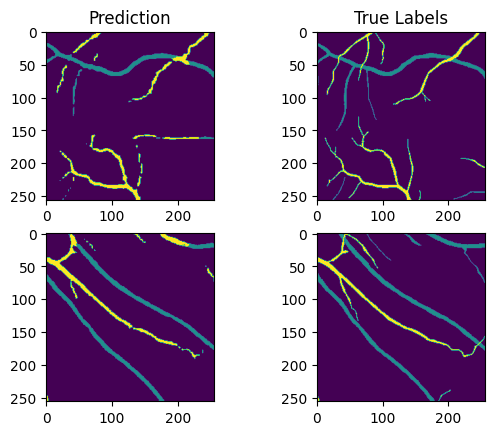

In [ ]:
model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_dataloader):
      pixel_values = batch["pixel_values"].to(device)
      print(torch.max(batch["pixel_values"]))
      print(torch.min(batch["pixel_values"]))
      labels = batch["labels"].to(device)

      outputs = model(pixel_values=pixel_values, labels=labels)
      print(pixel_values.size())
      upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()
      accuracy = accuracy_score(pred_labels, true_labels)

plt.figure()
# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# display images
axarr[0,0].imshow(predicted[0,:,:].detach().cpu().numpy())
axarr[0,0].title.set_text('Prediction')
axarr[0,1].imshow(labels[0,:,:].detach().cpu().numpy())
axarr[0,1].title.set_text('True Labels')
axarr[1,0].imshow(predicted[1,:,:].detach().cpu().numpy())
axarr[1,1].imshow(labels[1,:,:].detach().cpu().numpy())


In [ ]:
# Functions for sliding window method

# Given an image, the following function breaks it into pathces
def get_patches(image, H, W, patch_height, patch_width):
  patches = []

  for y in range(0, H, Hp):
        for x in range(0, W, Wp):
            patch = image[y:y+patch_height, x:x+patch_width, :]
            # print(np.shape(patch))
            # print(type(patch))
            patches.append(patch)

  return patches

# Given a list of patches, this function reconstruct an image
def reconstruct_image(patches, H, W, Hp, Wp):
  # Create an empty canvas to reconstruct the image
  img = np.zeros((H, W), dtype=np.float32)

  index = 0
  for y in range(0, H, Hp):
    for x in range(0, W, Wp):
        img[y:y+Hp, x:x+Wp] = patches[index]
        index += 1

  return img


# Given path to directory with images and patch size, this function return a list of patches per image
def get_all_patches(root_dir, patch_height, patch_width):


  # Create a list of image file names in the directory
  image_dir = os.path.join(root_dir, "images")
  image_file_names = sorted(os.listdir(image_dir))
  image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

  all_patches = []
  # Loop over the images, read, divide into patches, and display the patches
  for image_path in image_file_paths:
      # Read the image

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Get image dimensions
      height, width, _ = image.shape

      patches = get_patches(image, height, width, patch_height, patch_width)
      all_patches.append(patches)
  return all_patches, image_file_names

# Given an image, this function displays it
def show_image(image):
  plt.imshow(image)
  plt.title("Reconstructed Image")
  plt.axis("off")
  plt.show()

In [ ]:
def calc_reconstruct_outputs(root_dir=root_dir,mode="validation"):
  image_dir = root_dir + '/validation' if mode == "validation"  else root_dir + '/test'
  list_of_patches, sorted_file_names = get_all_patches(image_dir, Hp, Wp)

  num_of_images = len(list_of_patches)
  num_of_patches_per_image = len(list_of_patches[0])
  reconstructed_outputs = []

  model.eval()
  with torch.no_grad():
    for img_index in range(num_of_images):
      patches_orig = np.array(list_of_patches[img_index][:])
      patches = np.moveaxis(patches_orig,3,1).astype('float32')/255
      patches = torch.tensor(patches)
      predicted_patches = np.zeros(np.shape(patches_orig))
      pixel_values = patches.to(device)
      outputs = model(pixel_values=pixel_values)
      upsampled_logits = nn.functional.interpolate(outputs.logits, size=(256,256), mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      pred_labels = predicted.detach().cpu().numpy()
      new_image = reconstruct_image(pred_labels, 768, 768, 256, 256)
      reconstructed_outputs.append(new_image)
  return reconstructed_outputs, sorted_file_names

In [ ]:
val_reconstructed_outputs, val_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="validation")
test_reconstructed_outputs, test_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="test")

In [ ]:
# Dice similarity function
def dice(pred, true, label = 1):
    intersection = np.sum(pred[true==label]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

<Figure size 640x480 with 0 Axes>

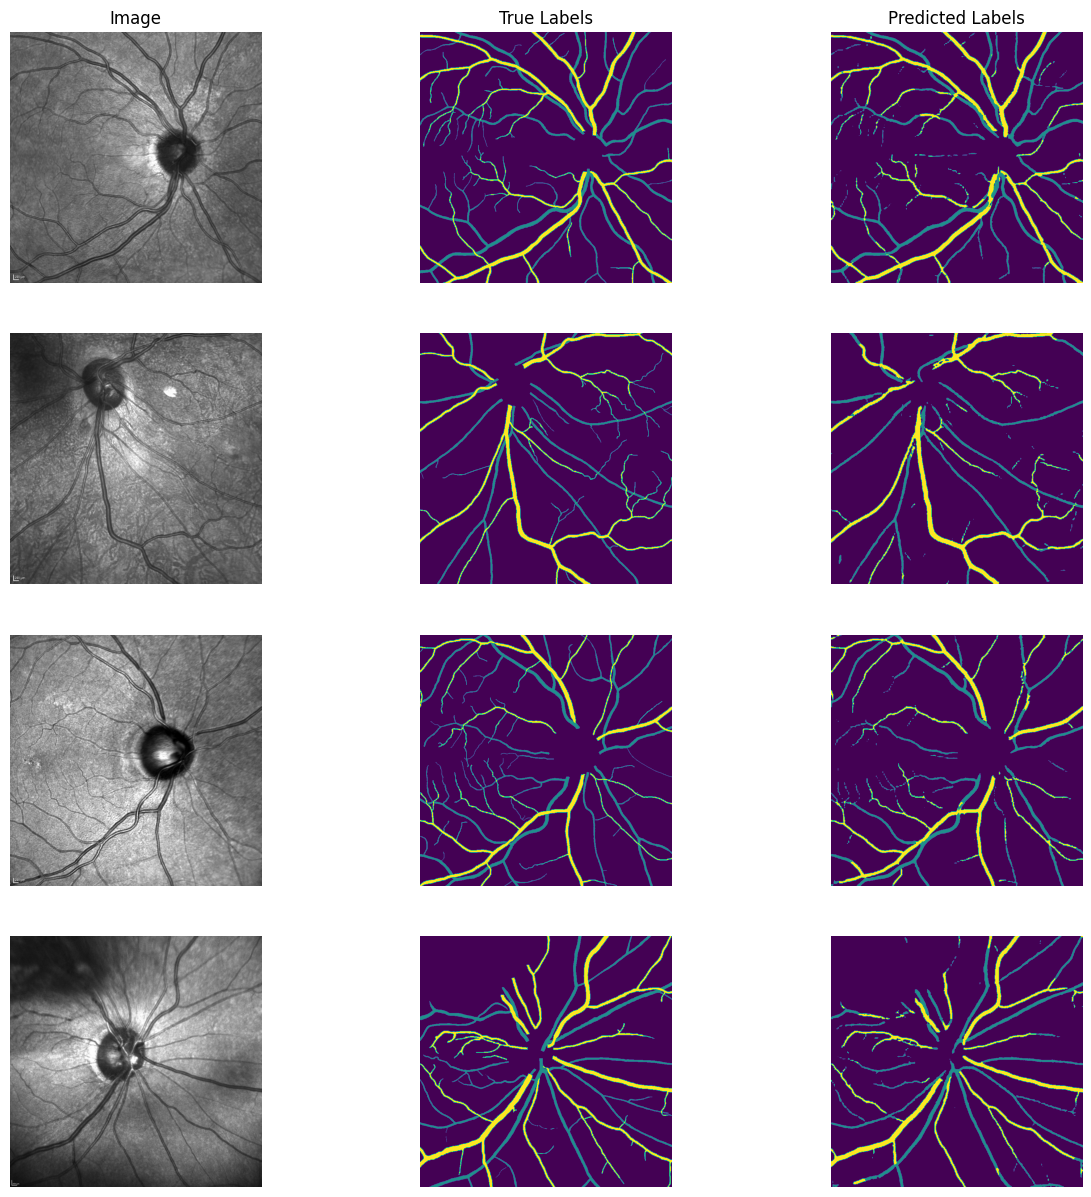

In [ ]:
# visually compare images to labels and network outputs (validation dataset)
plt.figure()

f, axarr = plt.subplots(len(valid_dataset_test),3,figsize=(15, 15))
axarr[0,0].title.set_text('Image')
axarr[0,1].title.set_text('True Labels')
axarr[0,2].title.set_text('Predicted Labels')

for i in range(len(valid_dataset_test)):
  encoded_inputs = valid_dataset_test[i]
  mask = encoded_inputs["labels"]
  pixel_vals = encoded_inputs["pixel_values"].numpy()
  norm = cv2.normalize(np.moveaxis(pixel_vals,0,-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  axarr[i,0].imshow(norm)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(mask.numpy())
  axarr[i,1].axis('off')
  axarr[i,2].imshow(val_reconstructed_outputs[i])
  axarr[i,2].axis('off')

  dice_arteries_total = []
  dice_veins_total = []
  metrics_total = []

  # create a table of metrics for each whole image
  for i in range(len(valid_dataset_test)):
    encoded_inputs = valid_dataset_test[i]
    true_labels = encoded_inputs["labels"].numpy()
    predictions = val_reconstructed_outputs[i]
    dice_arteries = dice(predictions, true_labels, label=1)
    dice_veins = dice(predictions, true_labels, label=2)
    dice_arteries_total.append(dice_arteries)
    dice_veins_total.append(dice_veins)
    target_names = ['background', 'arteries', 'veins']
    metrics = classification_report(true_labels.flatten(), predictions.flatten(), labels = [0,1,2], target_names=target_names, output_dict = True)
    metrics_total.append(metrics)


In [ ]:
# Create table of metrics for validation set (only relevent if not training on all data*)
ArteriesSummary = PrettyTable(["Accuracy (precision)","Sensitivity (recall)", "DICE"])
VeinsSummary = PrettyTable(["Accuracy (precision)","Sensitivity (recall)", "DICE"])
acc_veins = 0
acc_arteries = 0
sens_veins = 0
sens_arteries = 0
for index in range(len(metrics_total)):

    acc_arteries += metrics_total[index]['arteries']['precision']
    sens_arteries += metrics_total[index]['arteries']['recall']
    acc_veins += metrics_total[index]['veins']['precision']
    sens_veins += metrics_total[index]['veins']['recall']

ArteriesSummary.add_row([acc_arteries/len(dice_arteries_total), sens_arteries/len(dice_arteries_total), sum(dice_arteries_total)/len(dice_arteries_total)])
VeinsSummary.add_row([acc_veins/len(dice_veins_total), sens_veins/len(dice_veins_total), sum(dice_veins_total)/len(dice_veins_total)])

print('Arteries Summary')
print(ArteriesSummary)

print('Veins Summary')
print(VeinsSummary)

Arteries Summary
+----------------------+----------------------+---------------------+
| Accuracy (precision) | Sensitivity (recall) |         DICE        |
+----------------------+----------------------+---------------------+
|  0.7934284966765566  |  0.7829069297711903  | 0.26355357055809475 |
+----------------------+----------------------+---------------------+
Veins Summary
+----------------------+----------------------+--------------------+
| Accuracy (precision) | Sensitivity (recall) |        DICE        |
+----------------------+----------------------+--------------------+
|  0.8205563856135911  |  0.8122390966353978  | 0.5989394200978182 |
+----------------------+----------------------+--------------------+


<Figure size 640x480 with 0 Axes>

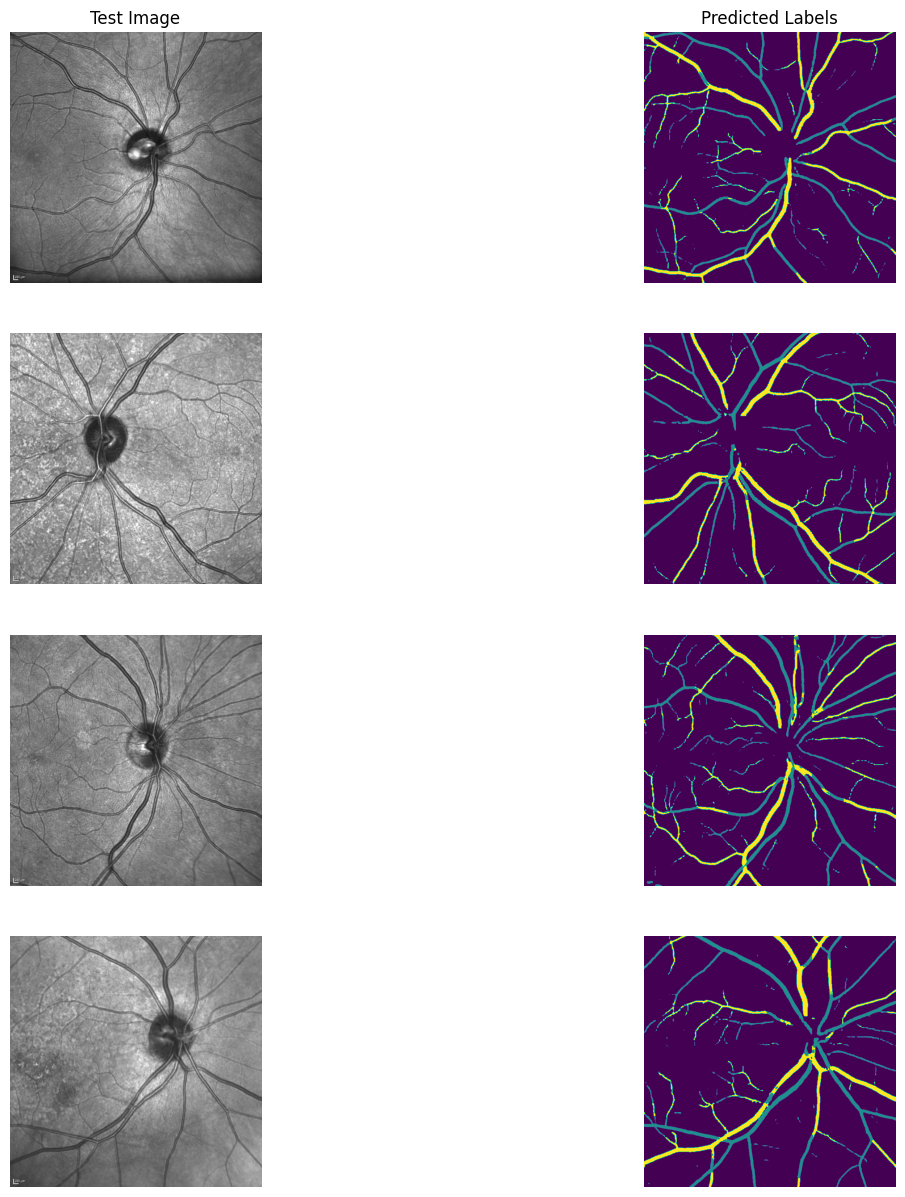

In [ ]:
# Display some test images and predictions

plt.figure()

f, axarr = plt.subplots(4,2,figsize=(15, 15))
axarr[0,0].title.set_text('Test Image')
axarr[0,1].title.set_text('Predicted Labels')

for i in range(4):
  pixel_vals = cv2.imread(os.path.join(root_dir,'test','images', test_sorted_file_names[i+4]))
  pixel_vals = cv2.cvtColor(pixel_vals, cv2.COLOR_BGR2RGB)
  norm = cv2.normalize(np.moveaxis(pixel_vals,0,-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  axarr[i,0].imshow(pixel_vals)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(test_reconstructed_outputs[i+4])
  axarr[i,1].axis('off')

In [ ]:
# Save test images by name

# Create new directory to save test outputs
new_directory_name = 'Test_eval'
new_directory_path = os.path.join(root_dir,'test', new_directory_name)
os.makedirs(new_directory_path, exist_ok=True)

# Save test outputs
for output, file_name in zip(test_reconstructed_outputs, test_sorted_file_names):
  file_p = os.path.join(root_dir,'test',new_directory_name, file_name)
  output = output * 128
  cv2.imwrite(file_p, output)

In [ ]:
import imageio as iio
mask_original = cv2.imread(os.path.join(root_dir,'train','mask', 'IR_Case_058.png'),cv2.IMREAD_UNCHANGED)
img = iio.imread(os.path.join(root_dir,'train','mask', 'IR_Case_058.png'))
np.unique(img)

<ipython-input-35-67bf24e7c13a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(os.path.join(root_dir,'train','mask', 'IR_Case_058.png'))


array([  0, 128, 255], dtype=uint8)

In [ ]:
import os
mask = cv2.imread(os.path.join('./drive/MyDrive/Deep Learning Class/RAVIR','test','Test_eval', 'IR_Case_060.png'),cv2.IMREAD_UNCHANGED)

In [ ]:
np.unique(mask)

array([  0, 128, 255], dtype=uint8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np

im = cv2.imread('./drive/MyDrive/Deep Learning Class/RAVIR/train/mask/IR_Case_049.png',cv2.IMREAD_UNCHANGED)
np.unique(im)

array([  0, 128, 255], dtype=uint8)